## Prediction

In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib inline

In [2]:
import numpy as np
import sys
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from functools import partial
from scipy.ndimage import gaussian_filter
import pathos.multiprocessing as mp
from ssrs.raster import transform_coordinates, transform_bounds
from ssrs.utils import get_extent_from_bounds
from ssrs.movmodel import MovModel
from dataclasses import replace, asdict
from ssrs import Terrain, Simulator, Config, WTK
import cartopy.crs as ccrs
from copy import deepcopy
import warnings
import scipy.spatial as spatial
#warnings.filterwarnings("ignore")
clrs = ['#377eb8', '#ff7f00', '#4daf4a',
        '#f781bf', '#a65628', '#984ea3',
        '#999999', '#e41a1c', '#dede00']

In [3]:
from bayesfilt.telemetry.utils import *
from bayesfilt.telemetry import Data3DEP, DataHRRR, Telemetry, TelemetryPlotter
from simulate_tracks import *

In [4]:
%%time
df, _ = get_annotated_telemetry_df()

CPU times: user 27.3 s, sys: 22.3 s, total: 49.6 s
Wall time: 38.2 s


In [5]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12975662 entries, 0 to 12975661
Data columns (total 286 columns):
 #    Column                Dtype         
---   ------                -----         
 0    AccelerationVer       float32       
 1    AccelerationX         float32       
 2    AccelerationX_var     float32       
 3    AccelerationY         float32       
 4    AccelerationY_var     float32       
 5    AccelerationZ_var     float32       
 6    AccnHorRadial         float32       
 7    AccnHorTangential     float32       
 8    Age                   category      
 9    Altitude              float32       
 10   AltitudeAgl           float32       
 11   Altitude_var          float32       
 12   AnimalID              int64         
 13   BoundaryLayerHeight   float32       
 14   FalseFix              bool          
 15   GroundAspect          float32       
 16   Elev                  float32       
 17   ElevD100              float32       
 18   ElevD1000         

In [6]:
model_str = 'fit_ca.pickle_robust'
with open(os.path.join(OUT_DIR,f'{model_str}_model'), 'rb') as outp:
    models = pickle.load(outp)
with open(os.path.join(OUT_DIR,f'{model_str}_funcs'), 'rb') as outp:
    std_funcs = pickle.load(outp)
with open(os.path.join(OUT_DIR,f'{model_str}_df'), 'rb') as outp:
    dfshort = pickle.load(outp)

In [7]:
#f'{model_str}_simulation_r75' works
case_str = f'{model_str}_simulation_r75'
#case_str = f'{model_str}_simulation_5min_r75_100'
with open(os.path.join(OUT_DIR, case_str), "rb") as f:
    results = pickle.load(f)
def get_xy_data(idf, xname, yname):
    quant = 0.95
    xgrid = np.linspace(*np.quantile(idf[xname], [1 - quant, quant]), 50)
    rdfshortb = pd.DataFrame({'x': idf[xname], 'y': idf[yname]})
    rdfshortb['bin_col'] = np.searchsorted(xgrid, idf[xname])
    bin_groups = rdfshortb.groupby(by='bin_col')
    ydata = bin_groups['y'].median()[:-1]
    yerr = bin_groups['y'].std()[:-1]
    ydata = ydata.rolling(3, min_periods=1, center=True).mean().bfill().ffill()
    return xgrid, ydata, yerr
print(len(results))

200


In [8]:
def save_paper_figure_validation(fig, name):
    fig.set_size_inches(7.5, 3)
    fig.subplots_adjust(left=0.01, bottom=0.1, right=0.91, top=0.98)
    fig.savefig(os.path.join(FIG_DIR, f'{name.lower()}.png'), dpi=200)

['pa']
Categories (3, object): ['hr', 'pa', 'wy']


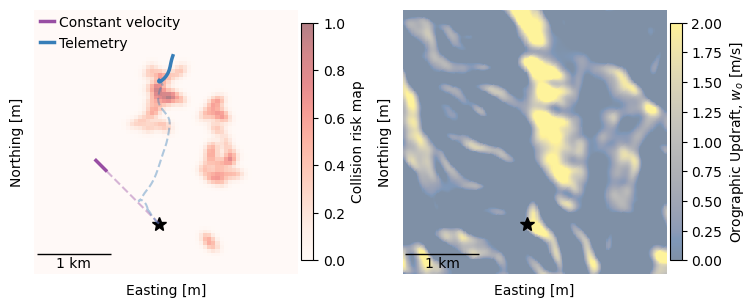

In [9]:
itrack = 104#22, 23, 130, 152, 156, 176
colnames = [
    'Altitude', 'Agl', 'VelocityVer', 'VelocityHor', 'HeadingRate', 'Heading',
    'WindLateral80m', 'WindSupport80m', 'WindRelativeAngle80m',#'ElevNearDiff'
    'WindDirection80m', 'WindSpeed80m', 
]
fig, ax = plot_sim_tracks_in_space2(results[itrack], max_agl=200., time_pad=[150,180], zoom=1800, savefig=False)
save_paper_figure_validation(fig, name=f'track_{itrack}_model')

['pa']
Categories (3, object): ['hr', 'pa', 'wy']


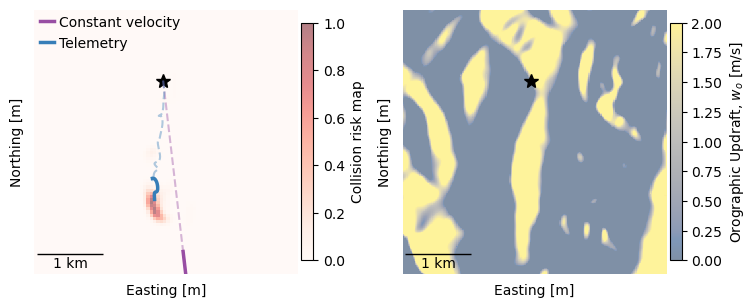

In [10]:
itrack = 9#22, 23, 130, 152, 156, 176
colnames = [
    'Altitude', 'Agl', 'VelocityVer', 'VelocityHor', 'HeadingRate', 'Heading',
    'WindLateral80m', 'WindSupport80m', 'WindRelativeAngle80m',#'ElevNearDiff'
    'WindDirection80m', 'WindSpeed80m', 
]
fig, ax = plot_sim_tracks_in_space2(results[itrack], max_agl=200., time_pad=[150,180], zoom=2000, savefig=False)
save_paper_figure_validation(fig, name=f'track_{itrack}_model')

['wy']
Categories (3, object): ['hr', 'pa', 'wy']


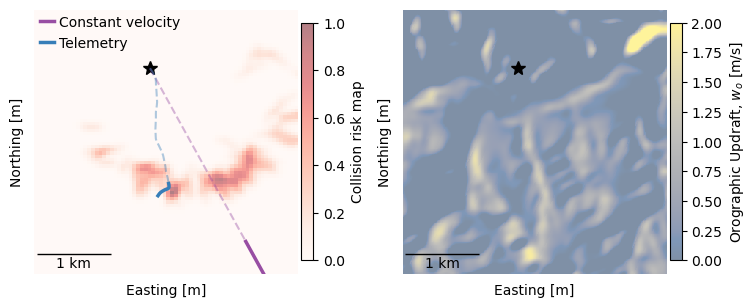

In [11]:
itrack = 34#22, 23, 130, 152, 156, 176
colnames = [
    'Altitude', 'Agl', 'VelocityVer', 'VelocityHor', 'HeadingRate', 'Heading',
    'WindLateral80m', 'WindSupport80m', 'WindRelativeAngle80m',#'ElevNearDiff'
    'WindDirection80m', 'WindSpeed80m', 
]
fig, ax = plot_sim_tracks_in_space2(results[itrack], max_agl=200., time_pad=[150,180], zoom=1800, savefig=False)
save_paper_figure_validation(fig, name=f'track_{itrack}_model')

['wy']
Categories (3, object): ['hr', 'pa', 'wy']


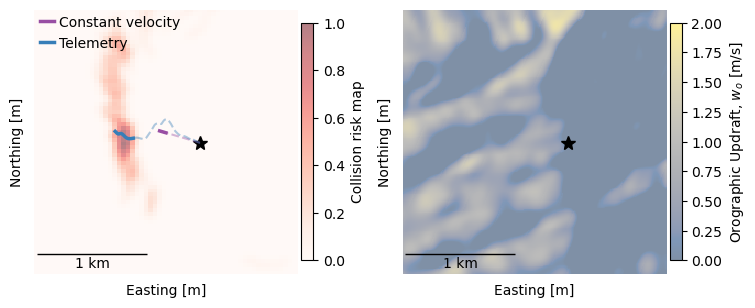

In [12]:
itrack = 7#22, 23, 130, 152, 156, 176
colnames = [
    'Altitude', 'Agl', 'VelocityVer', 'VelocityHor', 'HeadingRate', 'Heading',
    'WindLateral80m', 'WindSupport80m', 'WindRelativeAngle80m',#'ElevNearDiff'
    'WindDirection80m', 'WindSpeed80m', 
]
fig, ax = plot_sim_tracks_in_space2(results[itrack], max_agl=200., time_pad=[150,180], zoom=1200, savefig=False)
save_paper_figure_validation(fig, name=f'track_{itrack}_model')

In [18]:
list_of_dfs = []
list_of_tlocs = [30, 60, 90, 120,150,180]
for err_at in list_of_tlocs:
    hpos_err = []
    for ituple in results:
        ix, idf, ids, ilist_of_df = ituple
        xdiff = idf['PositionX'].iloc[1] - idf['PositionX'].iloc[0]
        ydiff = idf['PositionY'].iloc[1] - idf['PositionY'].iloc[0]
        heading = np.arctan2(xdiff, ydiff)
        for jdf in ilist_of_df:
            heading = np.radians(jdf['Heading'].iloc[0])
            hspeed = idf['VelocityHor'].iloc[0]
            vspeed = idf['VelocityVer'].iloc[0]
            xloc = jdf['PositionX'].iloc[0] + np.sin(heading)*hspeed*err_at
            yloc = jdf['PositionY'].iloc[0] + np.cos(heading)*hspeed*err_at
            zloc = jdf['Altitude'].iloc[0] + vspeed*err_at
            xerr = xloc-idf['PositionX'].iloc[err_at]
            yerr = yloc-idf['PositionY'].iloc[err_at]
            zerr = zloc-idf['Altitude'].iloc[err_at]
            hpos_err.append({'xres':xerr, 'yres':yerr,'zres':zerr})
    edf = pd.DataFrame(hpos_err)
    edf['rdist'] = np.sqrt(1*edf['xres']**2 + 1*edf['yres']**2 + 1*edf['zres']**2)
    list_of_dfs.append(edf)
rdist_adhoc = [idf['rdist'] for idf in list_of_dfs]

In [50]:
list_of_dfs = []
for err_at in list_of_tlocs:
    hpos_err = []
    for ituple in results:
        ix, idf, ids, ilist_of_df = ituple
        iidf = idf.iloc[err_at-1]
        ibool = True
        if ibool:
            for jdf in ilist_of_df:
                #print(jdf.shape[0], err_at)
                if jdf.shape[0] >= err_at:
                    jjdf = jdf.iloc[err_at-1]
                    jbool = True
                    if jbool:
                        xerr = jjdf['PositionX']-iidf['PositionX']
                        yerr = jjdf['PositionY']-iidf['PositionY']
                        zerr = jjdf['Altitude']-jjdf['Elev']-iidf['AltitudeAgl']
                        hpos_err.append({'xres':xerr, 'yres':yerr,'zres':zerr})
    edf = pd.DataFrame(hpos_err)
    edf['rdist'] = np.sqrt(1*edf['xres']**2 + 1*edf['yres']**2 + 1*edf['zres']**2)
    list_of_dfs.append(edf)
rdist_model = [idf['rdist'] for idf in list_of_dfs]

In [105]:
list_of_dfs = []
for err_at in list_of_tlocs:
    hpos_err = []
    for ituple in results:
        ix, idf, ids, ilist_of_df = ituple
        iidf = idf.iloc[err_at-1]
        ibool = (idf['WindSpeed80m'].quantile(0.9) > 3.)
        #ibool = ibool & (idf['OroSmooth'].quantile(0.5) > 0.75)
        ibool = ibool & (iidf['Agl']<200) & (iidf['WindSpeed80m']>3.) & (iidf['OroSmooth']>0.75)
        #ibool = (iidf['Agl']<200) & (iidf['WindSpeed80m']>3.) & (ids.WindSpeed80m.quantile(0.9).item() > 3.)
        if ibool:
            for jdf in ilist_of_df:
                if jdf.shape[0] >= err_at:
                    jjdf = jdf.iloc[err_at-1]
                    jbool = (jjdf['Agl']<200) & (jjdf['WindSpeed80m']>3) & (jjdf['OroSmooth']>0.75)
                    jbool = True
                    if jbool:
                        xerr = jjdf['PositionX']-iidf['PositionX']
                        yerr = jjdf['PositionY']-iidf['PositionY']
                        zerr = jjdf['Altitude']-jjdf['Elev'] -iidf['AltitudeAgl']
                        hpos_err.append({'xres':xerr, 'yres':yerr,'zres':zerr})
    edf = pd.DataFrame(hpos_err)
    edf['rdist'] = np.sqrt(1*edf['xres']**2 + 1*edf['yres']**2 + 1*edf['zres']**2)
    list_of_dfs.append(edf)
rdist_model_windy = [idf['rdist'] for idf in list_of_dfs]

In [113]:
5*np.sin(np.radians(9))

0.7821723252011543

In [59]:
# list_of_dfs = []
# for err_at in list_of_tlocs:
#     hpos_err = []
#     for ituple in results:
#         ix, idf, ids, ilist_of_df = ituple
#         iidf = idf.iloc[err_at-1]
#         ibool = (iidf['Agl']<150) & (iidf['WindSpeed80m']>5)
#         if ibool:
#             for jdf in ilist_of_df:
#                 #print(jdf.shape[0], err_at)
#                 if jdf.shape[0] >= err_at:
#                     jjdf = jdf.iloc[err_at-1]
#                     jbool = (jjdf['Agl']<150) & (jjdf['WindSpeed80m']>5)
#                     if jbool:
#                         xerr = jjdf['PositionX']-iidf['PositionX']
#                         yerr = jjdf['PositionY']-iidf['PositionY']
#                         zerr = jjdf['Altitude']-iidf['Altitude']
#                         hpos_err.append({'xres':xerr, 'yres':yerr,'zres':zerr})
#     edf = pd.DataFrame(hpos_err)
#     edf['rdist'] = np.sqrt(1*edf['xres']**2 + 1*edf['yres']**2 + 1*edf['zres']**2)
#     list_of_dfs.append(edf)
# rdist_model_windy = [idf['rdist'] for idf in list_of_dfs]

In [38]:
list_of_dfs = []
for err_at in list_of_tlocs:
    hpos_err = []
    for ituple in results:
        ix, idf, ids, ilist_of_df = ituple
        iidf = idf.iloc[err_at-1]
        #ibool = (iidf['Agl']<150) & (iidf['WindSpeed80m']>3) & (iidf['VelocityVer']>0)
        ibool = (iidf['Agl']<150) & (iidf['WindSpeed80m']>5) & (iidf['OroSmooth']>0.5) & (iidf['VelocityVer']>-10)
        #ibool = ibool & (iidf['OroSmooth']>=0.0) & (iidf['VelocityVer']>0)
        if ibool:
            for jdf in ilist_of_df:
                #print(jdf.shape[0], err_at)
                if jdf.shape[0] >= err_at:
                    jjdf = jdf.iloc[err_at-1]
                    jbool = (jjdf['Agl']<150) & (jjdf['WindSpeed80m']>5) & (jjdf['OroSmooth']>0.5) & (jjdf['VelocityVer']>-10)
                    #jbool = (jjdf['Agl']<150) & (jjdf['WindSpeed80m']>3) & (jjdf['VelocityVer']>0)
                    #jbool = jbool & (jjdf['OroSmooth']>=0.0) & (jjdf['VelocityVer']>0.)
                    if jbool:
                        xerr = jjdf['PositionX']-iidf['PositionX']
                        yerr = jjdf['PositionY']-iidf['PositionY']
                        zerr = jjdf['Altitude']-iidf['Altitude']
                        hpos_err.append({'xres':xerr, 'yres':yerr,'zres':zerr})
    edf = pd.DataFrame(hpos_err)
    edf['rdist'] = np.sqrt(1*edf['xres']**2 + 1*edf['yres']**2 + 1*edf['zres']**2)
    list_of_dfs.append(edf)
rdist_model_windy_soaring = [idf['rdist'] for idf in list_of_dfs]

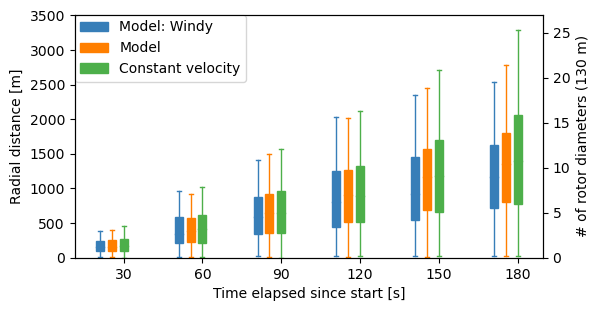

In [106]:
fig, ax = plt.subplots()
xlbls = [f'{ix}' for ix in list_of_tlocs]
dict_of_data = {
    #'Model: Windy+RSZ+Soaring': rdist_model_windy_rsz_soaring, 
    #'Model: Soaring': rdist_model_windy_soaring,
    'Model: Windy': rdist_model_windy, 
    'Model': rdist_model, 
    'Constant velocity': rdist_adhoc
}
list_of_pos_shift = [-0.3, -0.15, 0., 0.15, 0.3]
list_of_pos = [np.arange(len(list_of_tlocs)) for _ in range(len(dict_of_data))]
list_of_pos = [ix+iy for ix,iy in zip(list_of_pos, list_of_pos_shift)]
list_of_patches = []
ax2 = ax.twinx()
for i, (ilbl, idata) in enumerate(dict_of_data.items()):
    bp = ax.boxplot(
        idata,  
        sym='', 
        whis=1., 
        positions = list_of_pos[i], 
        widths=0.1, 
        meanline=True,
        patch_artist=True, 
        manage_ticks=False
    )
    for element in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(bp[element], color=clrs[i])
    list_of_patches.append(mpatches.Patch(color=clrs[i], label=ilbl))
#ax.grid(True)
ax.set_xticks(np.arange(len(list_of_tlocs)))
ax.set_xticklabels([30, 60, 90, 120, 150, 180])
ax.legend(handles=list_of_patches, loc=2, borderaxespad=0.)
ax.set_ylim([0,130*27])
ax2.set_ylim([0,27])
ax.set_xlabel('Time elapsed since start [s]')
ax.set_ylabel('Radial distance [m]')
ax2.set_ylabel('# of rotor diameters (130 m)')
fig.set_size_inches(6, 3)
fig.subplots_adjust(left=0.13, bottom=0.15, right=0.91, top=0.96)
fig.savefig(os.path.join(FIG_DIR, 'validation.png'), dpi=200)
#fig.savefig(os.path.join(FIG_DIR,f'fig_validation_{case_str}_radial.png'), dpi=200, bbox_inches='tight')

In [83]:
list_of_dfs = []
for err_at in list_of_tlocs:
    hpos_err = []
    for ituple in results:
        ix, idf, ids, ilist_of_df = ituple
        jbool = (idf['OroSmooth'].quantile(0.5) > 0.0)
        #jbool = (idf['VelocityVer'].quantile(0.5) > 0.0)
        #jbool = jbool & (idf['Agl'].quantile(0.75)<200)
        #jbool = jbool & (idf['VelocityHor'].quantile(0.75)>2.)
        #jbool = jbool & (ids.WindSpeed80m.median().item() > 5.)
        if jbool:
            for jdf in ilist_of_df:
                jbool = (jdf.shape[0] > err_at) & (jdf['OroSmooth'].quantile(0.5) > 0.0)
                if jbool:
                    #print(jdf['TrackTimeElapsed'].iloc[err_at], idf['TrackTimeElapsed'].iloc[err_at])
                    ibool = (jdf['Agl'].iloc[err_at] <1300) & (jdf['OroSmooth'].iloc[err_at] >= 0.0)
                    ibool = ibool & (jdf['VelocityVer'].iloc[err_at] > -100.)
                    if ibool:
                        xerr = jdf['PositionX'].iloc[err_at]-idf['PositionX'].iloc[err_at]
                        yerr = jdf['PositionY'].iloc[err_at]-idf['PositionY'].iloc[err_at]
                        zerr = jdf['Altitude'].iloc[err_at]-idf['Altitude'].iloc[err_at]
                        hpos_err.append({'xres':xerr, 'yres':yerr,'zres':zerr})
    edf = pd.DataFrame(hpos_err)
    edf['rdist'] = np.sqrt(1*edf['xres']**2 + 1*edf['yres']**2 + 1*edf['zres']**2)
    list_of_dfs.append(edf)
rdist_model = [idf['rdist'] for idf in list_of_dfs]

In [84]:
list_of_dfs = []
for err_at in list_of_tlocs:
    hpos_err = []
    for ituple in results:
        ix, idf, ids, ilist_of_df = ituple
        jbool = (idf['OroSmooth'].quantile(0.5) >= 0.0)
        #jbool = (idf['VelocityVer'].quantile(0.5) > 0.0)
        #jbool = jbool & (idf['Agl'].quantile(0.75)<150)
        #jbool = jbool & (idf['VelocityHor'].quantile(0.75)>2.)
        jbool = jbool & (ids.WindSpeed80m.quantile(0.75).item() > 10.)
        if jbool:
            for jdf in ilist_of_df:
                jbool = (jdf.shape[0] > err_at) & (jdf['OroSmooth'].quantile(0.5) > 0.0)
                if jbool:
                    #print(jdf['TrackTimeElapsed'].iloc[err_at], idf['TrackTimeElapsed'].iloc[err_at])
                    ibool = (jdf['Agl'].iloc[err_at] <1500) & (jdf['OroSmooth'].iloc[err_at] >= 0.0)
                    ibool = ibool & (jdf['VelocityVer'].iloc[err_at] > -100.)
                    if ibool:
                        xerr = jdf['PositionX'].iloc[err_at]-idf['PositionX'].iloc[err_at]
                        yerr = jdf['PositionY'].iloc[err_at]-idf['PositionY'].iloc[err_at]
                        zerr = jdf['Altitude'].iloc[err_at]-idf['Altitude'].iloc[err_at]
                        hpos_err.append({'xres':xerr, 'yres':yerr,'zres':zerr})
    edf = pd.DataFrame(hpos_err)
    edf['rdist'] = np.sqrt(1*edf['xres']**2 + 1*edf['yres']**2 + 1*edf['zres']**2)
    list_of_dfs.append(edf)
rdist_model_windy = [idf['rdist'] for idf in list_of_dfs]

In [85]:
list_of_dfs = []
for err_at in list_of_tlocs:
    hpos_err = []
    for ituple in results:
        ix, idf, ids, ilist_of_df = ituple
        jbool = (idf['OroSmooth'].quantile(0.5) > 0.0)
        #jbool = (idf['VelocityVer'].quantile(0.5) > 0.0)
        jbool = jbool & (idf['Agl'].quantile(0.75)<150)
        #jbool = jbool & (idf['VelocityHor'].quantile(0.75)>2.)
        #jbool = jbool & (ids.WindSpeed80m.median().item() > 10.)
        if jbool:
            for jdf in ilist_of_df:
                jbool = (jdf.shape[0] > err_at) & (jdf['OroSmooth'].quantile(0.5) >= 0.0)
                if jbool:
                    #print(jdf['TrackTimeElapsed'].iloc[err_at], idf['TrackTimeElapsed'].iloc[err_at])
                    ibool = (jdf['Agl'].iloc[err_at] <1300) & (jdf['OroSmooth'].iloc[err_at] >= 0.0)
                    ibool = ibool & (jdf['VelocityVer'].iloc[err_at] > -100.)
                    if ibool:
                        xerr = jdf['PositionX'].iloc[err_at]-idf['PositionX'].iloc[err_at]
                        yerr = jdf['PositionY'].iloc[err_at]-idf['PositionY'].iloc[err_at]
                        zerr = jdf['Altitude'].iloc[err_at]-idf['Altitude'].iloc[err_at]
                        hpos_err.append({'xres':xerr, 'yres':yerr,'zres':zerr})
    edf = pd.DataFrame(hpos_err)
    edf['rdist'] = np.sqrt(1*edf['xres']**2 + 1*edf['yres']**2 + 1*edf['zres']**2)
    list_of_dfs.append(edf)
rdist_model_windy_rsz = [idf['rdist'] for idf in list_of_dfs]

In [91]:
list_of_dfs = []
for err_at in list_of_tlocs:
    hpos_err = []
    for ituple in results:
        ix, idf, ids, ilist_of_df = ituple
        jbool = (idf['OroSmooth'].quantile(0.5) > 0.75)
        #jbool = (idf['VelocityVer'].quantile(0.5) > 0.0)
        #jbool = jbool & (idf['Agl'].quantile(0.75)<130)
        jbool = jbool & (idf['Agl'].quantile(0.75)<150)
        #jbool = jbool & (idf['VelocityHor'].quantile(0.75)>2.)
        jbool = jbool & (ids.WindSpeed80m.median().item() > 10.)
        if jbool:
            for jdf in ilist_of_df:
                jbool = (jdf.shape[0] > err_at) & (jdf['VelocityVer'].quantile(0.5) > 0.0)
                if jbool:
                    #print(jdf['TrackTimeElapsed'].iloc[err_at], idf['TrackTimeElapsed'].iloc[err_at])
                    #ibool = (jdf['Agl'].iloc[err_at] <130) & (jdf['OroSmooth'].iloc[err_at] > 0.75)
                    ibool = (jdf['Agl'].iloc[err_at] <150) & (jdf['OroSmooth'].iloc[err_at] >= 0.75)
                    ibool = ibool & (jdf['VelocityVer'].iloc[err_at] > 0.)
                    if ibool:
                        xerr = jdf['PositionX'].iloc[err_at]-idf['PositionX'].iloc[err_at]
                        yerr = jdf['PositionY'].iloc[err_at]-idf['PositionY'].iloc[err_at]
                        zerr = jdf['Altitude'].iloc[err_at]-idf['Altitude'].iloc[err_at]
                        hpos_err.append({'xres':xerr, 'yres':yerr,'zres':zerr})
    edf = pd.DataFrame(hpos_err)
    edf['rdist'] = np.sqrt(1*edf['xres']**2 + 1*edf['yres']**2 + 1*edf['zres']**2)
    list_of_dfs.append(edf)
rdist_model_windy_rsz_soaring = [idf['rdist'] for idf in list_of_dfs]

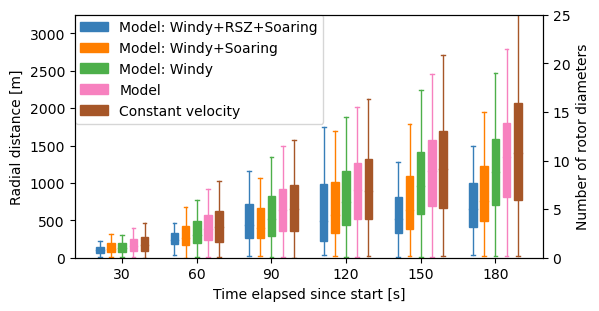

In [92]:
fig, ax = plt.subplots()
xlbls = [f'{ix}' for ix in list_of_tlocs]
dict_of_data = {
    'Model: Windy+RSZ+Soaring': rdist_model_windy_rsz_soaring, 
    'Model: Windy+Soaring': rdist_model_windy_soaring,
    'Model: Windy': rdist_model_windy, 
    'Model': rdist_model, 
    'Constant velocity': rdist_adhoc
}
list_of_pos_shift = [-0.3, -0.15, 0., 0.15, 0.3]
list_of_pos = [np.arange(len(list_of_tlocs)) for _ in range(len(dict_of_data))]
list_of_pos = [ix+iy for ix,iy in zip(list_of_pos, list_of_pos_shift)]
list_of_patches = []
ax2 = ax.twinx()
for i, (ilbl, idata) in enumerate(dict_of_data.items()):
    bp = ax.boxplot(
        idata,  
        sym='', 
        whis=1., 
        positions = list_of_pos[i], 
        widths=0.1, 
        meanline=True,
        patch_artist=True, 
        manage_ticks=False
    )
    for element in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(bp[element], color=clrs[i])
    list_of_patches.append(mpatches.Patch(color=clrs[i], label=ilbl))
#ax.grid(True)
ax.set_xticks(np.arange(len(list_of_tlocs)))
ax.set_xticklabels(xlbls)
ax.legend(handles=list_of_patches, loc=2, borderaxespad=0.)
ax.set_ylim([0,130*25])
ax2.set_ylim([0,25])
ax.set_xlabel('Time elapsed since start [s]')
ax.set_ylabel('Radial distance [m]')
ax2.set_ylabel('Number of rotor diameters')
fig.set_size_inches(6, 3)
fig.subplots_adjust(left=0.13, bottom=0.15, right=0.91, top=0.96)
fig.savefig(os.path.join(FIG_DIR, 'validation.png'), dpi=200)
#fig.savefig(os.path.join(FIG_DIR,f'fig_validation_{case_str}_radial.png'), dpi=200, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
xnames = [
    #'OroSmoothFiftyDiff', 'OroSmoothOnehdDiff', 'OroSmoothTwohdDiff', 'OroSmoothFvehdDiff', 'OroSmoothOnekmDiff',
    'OroSmoothFiftyDiffStd', 'OroSmoothOnehdDiffStd', 'OroSmoothTwohdDiffStd', 'OroSmoothFvehdDiffStd', 'OroSmoothOnekmDiffStd',
]
lstyles = ['-','--','-.',':', '-']
lbls = ['50 m', '100m', '250 m','500 m','1 km','2 km']
# name it in 
yname = 'VelocityVerNext'
#yname = 'AccnHorTangential'
#idf = dfshort[dfshort['OroSmoothFartherDiff']>dfshort['OroSmoothCloseDiff']]
idf = dfshort
quant = 0.95
# max of all oro's vs 
for i, xname in enumerate(xnames):
    xgrid = np.linspace(*np.quantile(idf[xname], [1 - quant, quant]), 50)
    rdfshortb = pd.DataFrame({'x': idf[xname], 'y': idf[yname]})
    rdfshortb['bin_col'] = np.searchsorted(xgrid, idf[xname])
    bin_groups = rdfshortb.groupby(by='bin_col')
    ydata = bin_groups['y'].mean()[:-1]
    yerr = bin_groups['y'].std()[:-1]
    ydata = ydata.rolling(7, min_periods=1, center=True).mean().bfill().ffill()
    ydata -= dfshort[yname].mean()
    ax.plot(xgrid, ydata, linestyle=lstyles[i], color=clrs[i], linewidth=2., alpha=0.75, label=lbls[i])
    #ax.plot(xgrid, ydata-yerr, linestyle='--', color=clrs[i], linewidth=2., alpha=0.75, label=lbls[i])
    #ax.plot(xgrid, ydata+yerr, linestyle='--', color=clrs[i], linewidth=2., alpha=0.75, label=lbls[i])
ax.legend(borderaxespad=0.)
ax.set_xlabel('Difference in orographic updraft from PF [m/s]')
ax.set_ylabel(r'$\Delta v_h$ around median [m/s]')
ax.grid(True)
#ax.set_xlim([0,1])
fig.tight_layout()
#fig.savefig(os.path.join(FIG_DIR,f'{yname}_oro.png'), dpi=200, bbox_inches='tight')

In [ ]:
dfshort.VelocityHor.mean()

In [ ]:
dfshort.groupby('Group')['TrackID'].count()*100/dfshort.shape[0]

In [ ]:
fig, ax = plt.subplots(figsize=(5.5,3))
xnames = ['OroSmoothNearL30Diff', 'OroSmoothNearR30Diff', 
          'OroSmoothCloseL30Diff', 'OroSmoothCloseR30Diff',
          #'OroSmoothNearL60Diff', 'OroSmoothNearR60Diff', 
          #'OroSmoothCloseL60Diff', 'OroSmoothCloseR60Diff',
          ]
lbls = ['F50L30','F50R30','F250L30','F250R30','F50L60','F50R60','F250L60','F250R60']
lbls = [r'50 m, -30$^o$', r'50 m, 30$^o$', r'250 m, -30$^o$',r'250 m, 30$^o$', 
        r'50 m, -60$^o$',r'50 m, 60$^o$', r'250 m, -60$^o$',r'250 m, 60$^o$']
#iclrs = [clrs[0], clrs[0]]
# F250
# color schemes for the two figures
yname = 'HeadingRateNext'
idf = dfshort
quant = 0.9
for i, xname in enumerate(xnames):
    xgrid = np.linspace(*np.quantile(idf[xname].abs(), [1 - quant, quant]), 50)
    rdfshortb = pd.DataFrame({'x': idf[xname].abs(), 'y': idf[yname]})
    rdfshortb['bin_col'] = np.searchsorted(xgrid, idf[xname])
    bin_groups = rdfshortb.groupby(by='bin_col')
    ydata = bin_groups['y'].mean()[:-1]
    yerr = bin_groups['y'].std()[:-1]
    ydata = ydata.rolling(7, min_periods=1, center=True).mean().bfill().ffill()
    ax.plot(xgrid, ydata, linestyle='-', color=clrs[i], linewidth=2., alpha=0.75, label=lbls[i])
ax.legend(borderaxespad=0., ncol=2)
ax.set_xlabel('Difference in orographic updraft from NF/CF [m/s]')
ax.set_ylabel('Heading rate, median [deg/s]')
ax.grid(True)
ax.set_xlim([-0.0,0.1])
ax.set_ylim([-0.4,0.4])
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR,f'{yname}_oro.png'), dpi=200, bbox_inches='tight')

In [ ]:
dfshort['OroSmoothNearLeftMaxDiff'] = np.maximum.reduce([
    dfshort['OroSmoothNearL15Diff'],
    dfshort['OroSmoothNearL30Diff'],
    dfshort['OroSmoothNearL60Diff']
])
dfshort['OroSmoothNearRightMaxDiff'] = np.maximum.reduce([
    dfshort['OroSmoothNearR15Diff'],
    dfshort['OroSmoothNearR30Diff'],
    dfshort['OroSmoothNearR60Diff']
])

In [ ]:
fig, ax = plt.subplots(figsize=(5.5,3))
case_dict = {
#     'OroSmoothNearLeftMaxDiff':'left max',
#      'OroSmoothNearRightMaxDiff':'right max',
    'OroSmoothNearL15Diff': r'50 m, -15$^o$', 
    'OroSmoothNearR15Diff': r'50 m, 15$^o$', 
    'OroSmoothNearL30Diff': r'50 m, -30$^o$', 
    'OroSmoothNearR30Diff': r'50 m, 30$^o$',
    'OroSmoothNearL60Diff': r'50 m, -60$^o$', 
    'OroSmoothNearR60Diff': r'50 m, 60$^o$',
}
# F250
# color schemes for the two figures
yname = 'HeadingRateNext'
idf = dfshort
quant = 0.9
for i, (xname, lbl) in enumerate(case_dict.items()):
    xgrid = np.linspace(*np.quantile(idf[xname], [1 - quant, quant]), 50)
    rdfshortb = pd.DataFrame({'x': idf[xname], 'y': idf[yname]})
    rdfshortb['bin_col'] = np.searchsorted(xgrid, idf[xname])
    bin_groups = rdfshortb.groupby(by='bin_col')
    ydata = bin_groups['y'].mean()[:-1]
    yerr = bin_groups['y'].std()[:-1]
    ydata = ydata.rolling(9, min_periods=1, center=True).mean().bfill().ffill()
    ax.plot(xgrid, ydata, linestyle='-', color=clrs[i], linewidth=2., alpha=0.75, label=lbl)
ax.legend(borderaxespad=0., ncol=3)
ax.set_xlabel('Difference in orographic updraft from NF/CF [m/s]')
ax.set_ylabel('Heading rate, median [deg/s]')
ax.grid(True)
ax.set_xlim([-0.3,0.3])
ax.set_ylim([-0.5,0.5])
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR,f'{yname}_oro2.png'), dpi=200, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(5.5,3))
case_dict = {
#     'OroSmoothNearLeftMaxDiff':'left max',
#      'OroSmoothNearRightMaxDiff':'right max',
    'OroSmoothCloseL15Diff': r'50 m, -15$^o$', 
    'OroSmoothCloseR15Diff': r'50 m, 15$^o$', 
    'OroSmoothCloseL30Diff': r'50 m, -30$^o$', 
    'OroSmoothCloseR30Diff': r'50 m, 30$^o$',
    'OroSmoothCloseL60Diff': r'50 m, -60$^o$', 
    'OroSmoothCloseR60Diff': r'50 m, 60$^o$',
}
# F250
# color schemes for the two figures
yname = 'HeadingRateNext'
idf = dfshort
quant = 0.9
for i, (xname, lbl) in enumerate(case_dict.items()):
    xgrid = np.linspace(*np.quantile(idf[xname], [1 - quant, quant]), 50)
    rdfshortb = pd.DataFrame({'x': idf[xname], 'y': idf[yname]})
    rdfshortb['bin_col'] = np.searchsorted(xgrid, idf[xname])
    bin_groups = rdfshortb.groupby(by='bin_col')
    ydata = bin_groups['y'].mean()[:-1]
    yerr = bin_groups['y'].std()[:-1]
    ydata = ydata.rolling(9, min_periods=1, center=True).mean().bfill().ffill()
    ax.plot(xgrid, ydata, linestyle='-', color=clrs[i], linewidth=2., alpha=0.75, label=lbl)
ax.legend(borderaxespad=0., ncol=3)
ax.set_xlabel('Difference in orographic updraft from NF/CF [m/s]')
ax.set_ylabel('Heading rate, median [deg/s]')
ax.grid(True)
ax.set_xlim([-0.3,0.3])
ax.set_ylim([-0.5,0.5])
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR,f'{yname}_oro2.png'), dpi=200, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(5.5,3))
xnames = ['OroSmoothNearL30Diff', 'OroSmoothNearR30Diff', 
          #'OroSmoothCloseL30Diff', 'OroSmoothCloseR30Diff',
          'OroSmoothNearL60Diff', 'OroSmoothNearR60Diff', 
          #'OroSmoothCloseL60Diff', 'OroSmoothCloseR60Diff',
          ]
lbls = ['F50L30','F50R30','F250L30','F250R30','F50L60','F50R60','F250L60','F250R60']
lbls = [r'250 m, -30$^o$',r'250 m, 30$^o$',r'250 m, -60$^o$',r'250 m, 60$^o$']
#iclrs = [clrs[0], clrs[0]]
# F250
# color schemes for the two figures
yname = 'HeadingRateNext'
idf = dfshort
quant = 0.9
for i, xname in enumerate(xnames):
    xgrid = np.linspace(*np.quantile(idf[xname], [1 - quant, quant]), 50)
    rdfshortb = pd.DataFrame({'x': idf[xname], 'y': idf[yname]})
    rdfshortb['bin_col'] = np.searchsorted(xgrid, idf[xname])
    bin_groups = rdfshortb.groupby(by='bin_col')
    ydata = bin_groups['y'].mean()[:-1]
    yerr = bin_groups['y'].std()[:-1]
    ydata = ydata.rolling(7, min_periods=1, center=True).mean().bfill().ffill()
    ax.plot(xgrid, ydata, linestyle='-', color=clrs[i], linewidth=2., alpha=0.75, label=lbls[i])
ax.legend(borderaxespad=0., ncol=2)
ax.set_xlabel('Difference in orographic updraft from NF/CF [m/s]')
ax.set_ylabel('Heading rate, median [deg/s]')
ax.grid(True)
ax.set_xlim([-0.1,0.1])
ax.set_ylim([-0.4,0.4])
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR,f'{yname}_oro2.png'), dpi=200, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(4.5,3))
idf = dfshort[dfshort['WindSpeed80m']<100.]
xdata, ydata, ystd = get_xy_data(idf, 'WindSupport80m','VelocityHorNext')
ax.plot(xdata, ydata, '-r', color=clrs[0],linewidth=2., alpha=0.75, label='Tailwind')
xdata, ydata, ystd = get_xy_data(idf, 'WindLateral80m','VelocityHorNext')
ax.plot(xdata, ydata, '-b', color=clrs[1], linewidth=2., alpha=0.75, label='Crosswind')
# xdata, ydata, ystd = get_xy_data(dfshort, 'WindSpeed80m','VelocityVerNext')
# ax.plot(xdata, ydata, '-b', linewidth=2., alpha=0.75)
ax.legend(borderaxespad=0.)
ax.set_xlabel('Wind speed [m/s]')
ax.set_ylabel(r'Horizontal speed, median [m/s]')
ax.grid(True)
# ax.set_xlim([-5,5])
# ax.set_ylim([-0.5,0.5])
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR,'fig_wind_velocityhor.png'), dpi=200, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(4.5,3))
idf = dfshort[dfshort['WindSpeed80m']<100.]
xdata, ydata, ystd = get_xy_data(idf, 'WindSupport80m','VelocityVerNext')
ax.plot(xdata, ydata, '-r', color=clrs[0],linewidth=2., alpha=0.75, label='Tailwind')
xdata, ydata, ystd = get_xy_data(idf, 'WindLateral80m','VelocityVerNext')
ax.plot(xdata, ydata, '-b', color=clrs[1], linewidth=2., alpha=0.75, label='Crosswind')
xdata, ydata, ystd = get_xy_data(dfshort, 'WindSpeed80m','VelocityVerNext')
#ax.plot(xdata, ydata, '-b', linewidth=2., alpha=0.75, label='Wind')
ax.legend(borderaxespad=0.)
ax.set_xlabel('Wind speed [m/s]')
ax.set_ylabel('Vertical speed, median [m/s]')
ax.grid(True)
# ax.set_xlim([-5,5])
# ax.set_ylim([-0.5,0.5])
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR,'fig_wind_velocityver.png'), dpi=200, bbox_inches='tight')

In [ ]:
dfshort.WindSpeed80m.hist(bins=100)

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
xnames = ['OroSmoothNearDiff', 'OroSmoothCloseDiff', 'OroSmoothMidDiff', 
          'OroSmoothFarDiff']
clrs = ['b','r','g','c','k']
lbls = ['NF-PF','CF-PF','MF-PF','FF-PF','ddd']
yname = 'VelocityVerNext'
idf = dfshort
quant = 0.9999
for i, xname in enumerate(xnames):
    xgrid = np.linspace(*np.quantile(idf[xname], [1 - quant, quant]), 50)
    rdfshortb = pd.DataFrame({'x': idf[xname], 'y': idf[yname]})
    rdfshortb['bin_col'] = np.searchsorted(xgrid, idf[xname])
    bin_groups = rdfshortb.groupby(by='bin_col')
    ydata = bin_groups['y'].median()[:-1]
    yerr = bin_groups['y'].std()[:-1]
    ydata = ydata.rolling(7, min_periods=1, center=True).mean().bfill().ffill()
    ax.plot(xgrid, ydata, linestyle='-', color=clrs[i], linewidth=2., alpha=0.75, label=lbls[i])
ax.legend(borderaxespad=0.)
ax.set_xlabel('Variation in orographic updraft [m/s]')
ax.set_ylabel('Vertical speed [m/s]')
ax.grid(True)
ax.set_xlim([-2,2])
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR,f'{yname}_oro.png'), dpi=200, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
xnames = ['ElevNearDiff', 'ElevCloseDiff', 'ElevMidDiff', 'ElevFarDiff']
clrs = ['b','r','g','c','k']
lbls = ['NF-PF','CF-PF','MF-PF','FF-PF','ddd']
yname = 'HeadingRateNext'
idf = dfshort
quant = 0.9999
for i, xname in enumerate(xnames):
    xgrid = np.linspace(*np.quantile(idf[xname], [1 - quant, quant]), 50)
    rdfshortb = pd.DataFrame({'x': idf[xname], 'y': idf[yname]})
    rdfshortb['bin_col'] = np.searchsorted(xgrid, idf[xname])
    bin_groups = rdfshortb.groupby(by='bin_col')
    ydata = bin_groups['y'].mean()[:-1]
    yerr = bin_groups['y'].std()[:-1]
    ydata = ydata.rolling(3, min_periods=1, center=True).mean().bfill().ffill()
    #ydata -= idf['HeadingRate'].mean()
    ax.plot(xgrid, ydata, linestyle='-', color=clrs[i], linewidth=2., alpha=0.75, label=lbls[i])
ax.legend(borderaxespad=0.)
ax.set_xlabel('Variation in ground elevation [std]')
ax.set_ylabel('Vertical speed [std]')
ax.grid(True)
ax.set_xlim([-3,3])
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR,f'{yname}_elev.png'), dpi=200, bbox_inches='tight')

In [ ]:
try:
    idx, idf, ids, list_of_simdf  = sim_results[itrack]
    print('here')
except:
     idx, idf, ids  = sim_results[itrack]
lag_colnames = [ix.split('Next')[0] for ix in models.columns]
list_of_start_states = gather_starting_locs(
    [idx, idf, ids], 
    lag_cols=lag_colnames, 
    ntracks=10, 
    dict_of_scales={
            'PositionX': 10,
            'PositionY': 10,
            'Altitude': 2.,
            'VelocityHor': 1.,
            'VelocityVer': 1.,
            'HeadingRate': 0.1,
            'HrateByHspeed': 0.5,
            'Heading': 5.
        }
)
simdf = generate_track(
    start_state = list_of_start_states[0],
    ids=ids,
    models=models,
    std_funcs=std_funcs,
    num_steps=int(idf['TrackTimeElapsed'].iloc[-1]),
    mtype='LinReg',
    verbose=True
)

In [ ]:
models

In [ ]:
spoints = sdf[['PositionX','PositionY','Agl']].astype(int)
# spoints = 
# tree = spatial.KDTree(spoints)           

In [ ]:
rnge = [[ids.x.min(), ids.x.max()],[ids.y.min(), ids.y.max()]]
sdf = pd.concat(list_of_simdf)
sdf = sdf[sdf['TrackTimeElapsed'] > 0]
H,xedges,yedges= np.histogram2d(sdf['PositionX'], sdf['PositionY'], bins=100, range=rnge)
gf_func = partial(
    gaussian_filter,
    sigma=1,
    mode='constant',
    truncate=5,
    cval=0
)
X, Y = np.meshgrid(xedges, yedges)
H = gf_func(H)
H = H.T/np.amax(H)
fig, ax = plt.subplots(figsize=(5,5))
cm = ax.pcolormesh(X, Y, H, cmap='Reds', vmin=0.0)

fig.colorbar(cm)
ax.set_aspect('equal')

In [ ]:
plt.plot(sdf['PositionX'],sdf['PositionY'], '.r')

In [ ]:
points = np.array([(1, 2), (3, 4), (4, 5), (100,100)])
tree = spatial.KDTree(np.array(points))
radius = 3.0

neighbors = tree.query_ball_tree(tree, radius)
print(neighbors)

In [ ]:
csg = Telemetry(
        times=df['TimeUTC'],
        times_local=df['TimeLocal'],
        lons=df['Longitude'],
        lats=df['Latitude'],
        regions=df['Group'],
        df_add=df,
        out_dir=output_dir
)

In [ ]:
csg.info()

In [ ]:
ix = 42
gf_func = partial(
    gaussian_filter,
    sigma=5,
    mode='constant',
    truncate=5,
    cval=0
)
rdf, rds = csg.get_random_track_segment(
    time_len=300,
    out_dir=os.path.join(out_dir, f'track_{str(ix)}'),
    rnd_seed=ix,
    gf_func=gf_func,
    max_agl=300,
    min_xwidth_km=3,
    min_ywidth_km=3,
    xpad_km=1.5,
    ypad_km=1.5
)

In [ ]:
rdf.Agl.quantile(0.1)

In [ ]:
colnames = [
    'Agl', 'VelocityVer', 'VelocityHor', 'HeadingRate', 
    'WindLateral80m', 'WindSupport80m', 'WindRelativeAngle80m',#'ElevNearDiff'
    'WindDirection80m', 'WindSpeed80m', 'OroSmooth'
]
fig, ax = plot_sim_tracks_in_space((1,rdf, rds))
fig, ax = plot_sim_tracks_in_time((1,rdf, rds), colnames=colnames)

In [ ]:
rdf.head()

In [ ]:
ids.WindSpeed80m.plot()

In [ ]:
ids

In [ ]:
idf.columns

In [ ]:
fpath = os.path.join(telemetry_dir, 'csg_ge_vr.prq_tracks_ca_annotated')
df = pd.read_parquet(fpath)
df['Agl'] = df['Altitude'] - df['GroundElevation']
df['HeadingRateRaw'] = df['HeadingRate'].multiply(-1) 
df['HeadingRate'] = df['HeadingRateRaw'].rolling(3, min_periods=1, center=True).mean().bfill().ffill()
df['WindLateral80mAbs'] = df['WindLateral80m'].abs()
df.drop(columns=[ix for ix in df.columns if '_var' in ix], inplace=True)
df.drop(columns=[ix for ix in df.columns if '10m' in ix], inplace=True)
df.drop(columns=[ix for ix in df.columns if 'OroUpdraftD' in ix], inplace=True)
csg = Telemetry(
    times=df['TimeUTC'],
    times_local=df['TimeLocal'],
    lons=df['Longitude'],
    lats=df['Latitude'],
    regions=df['Group'],
    df_add=df,
    out_dir=output_dir
)
with open(csg.domain_fpath, 'rb') as outp:
    csg.df_subdomains = pickle.load(outp)
csg_plotter = TelemetryPlotter(csg)

In [ ]:
fpath = os.path.join(telemetry_dir, 'csg_ge_vr.prq_tracks')
vdf = pd.read_parquet(fpath, engine='fastparquet')
vcsg = Telemetry(
    times=vdf['TimeUTC'],
    times_local=vdf['TimeLocal'],
    lons=vdf['Longitude'],
    lats=vdf['Latitude'],
    regions=vdf['Group'],
    df_add=vdf,
    out_dir=output_dir
)
vcsg_plotter = TelemetryPlotter(vcsg)

In [ ]:
fig, ax = plt.subplots(figsize=(9,3))
track_id = 812
cname='PositionX'
csg_plotter.plot_track_in_time(track_id, cname, '.r', ax=ax)
vcsg_plotter.plot_track_in_time(track_id, cname, '-b', ax=ax)
#ax.set_xlim([150,190])
ax.grid(True)

In [ ]:
fig, ax = plt.subplots(figsize=(9,3))
track_id = 199
csg_plotter.plot_track_in_space(track_id,  '-r', ax=ax)
vcsg_plotter.plot_track_in_space(track_id,  '-b', ax=ax)
#ax.set_xlim([150,190])
ax.grid(True)
ax.set_aspect('equal')

In [ ]:
gf_func = partial(
        gaussian_filter,
        sigma=5,
        mode='constant',
        truncate=5,
        cval=0
    )
dfs, ds = csg.get_random_track_segment(
    time_len=300, 
    rnd_seed=1, 
    out_dir=output_dir,
    gf_func=gf_func,
    min_xwidth_km=3,
    min_ywidth_km=3,
    xpad_km=1.5,
    ypad_km=1.5
)
#list(ds.data_vars.keys())

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(8,3))
ax=ax.flatten()
cm = ax[0].pcolormesh(ds.x.values, ds.y.values, ds['GroundElevation'], cmap='terrain', alpha=0.15)
cm = ax[0].scatter(dfs['PositionX'],dfs['PositionY'],c=dfs['Agl'], s=0.4, cmap='Reds_r')
ax[0].plot(dfs['PositionX'].iloc[0], dfs['PositionY'].iloc[0], '*g')
cb = fig.colorbar(cm, ax=ax[0], label='AGL [m]')
cm = ax[1].pcolormesh(ds.x.values, ds.y.values, ds['OroSmooth'], cmap='viridis', alpha=0.5)
cb = fig.colorbar(cm, ax=ax[1], label='OroUpdraft [m/s]')
# cm = ax[2].pcolormesh(ds.x.values, ds.y.values, ds['WindDirection_80m'], cmap='viridis', alpha=0.5)
# cb = fig.colorbar(cm, ax=ax[2], label='Wind Direction [deg]')
# cm = ax[3].pcolormesh(ds.x.values, ds.y.values, ds['WindSpeed_80m'], cmap='viridis', alpha=0.5)
# cb = fig.colorbar(cm, ax=ax[3], label='Wind Speed [m/s]')
for iax in ax:
    iax.axis('off')
    iax.set_aspect('equal')
#ax[0].plot(dfs['PositionX'], dfs['PositionY'], '-r')
fig.tight_layout()

In [ ]:
with open(os.path.join(output_dir, 'fitted_models_ca.pickle'), 'rb') as outp:
    models= pickle.load(outp)
with open(os.path.join(output_dir, 'fitted_models_ca_std_funcs.pickle'), 'rb') as outp:
    std_funcs= pickle.load(outp)

In [ ]:
models.loc['Covariates','VelocityHorNextStd']

In [ ]:
num_tracks = 5
time_lags = [5, 10, 20]
lag_cols = [ix.split('Next')[0] for ix in models.columns]
num_steps = int(dfs['TrackTimeElapsed'].iloc[-1])
xlocs = np.random.normal(loc=dfs['PositionX'].iloc[0], scale=25., size=num_tracks)
ylocs = np.random.normal(loc=dfs['PositionY'].iloc[0], scale=25., size=num_tracks)
zlocs = np.random.normal(loc=dfs['Altitude'].iloc[0], scale=5., size=num_tracks)
start_state = {'TrackTimeElapsed':0.}
start_state |= {'Heading':dfs['Heading'].iloc[0]}
start_state |= {ix:dfs[ix].iloc[0] for ix in lag_cols}
start_state |= {f'{ix}Lag{iy}':dfs[ix].iloc[0] for ix in lag_cols for iy in time_lags}
start_state |= {f'{ix}Lag{iy}':0. for ix in lag_cols for iy in time_lags}
list_of_start_states = []
for xloc, yloc, zloc in zip(xlocs,ylocs,zlocs):
    istate = deepcopy(start_state)
    istate |= {'PositionX': xloc, 'PositionY': yloc, 'Altitude': zloc}
    list_of_start_states.append(istate)

In [ ]:
# istate = deepcopy(list_of_start_states[3])
# dist_dict = {'Near': [25,50,75], 'Mid': [400,500,600], 'Far': [900,1000,1100]}
# angle_dict = {'L30':-30, 'R30':30}
# if 'GroundElevation' in list(ds.data_vars.keys()):
#     ds = ds.rename({'GroundElevation':'Elev'})
# istate = annotate_env_conditions(istate, ds, dist_dict, angle_dict)
# istate = process_wind_conditions(istate, 80.)
# istate = annotate_lookahead_conditions(istate, dist_dict, np.mean, np.mean)

In [ ]:
if __name__ == "__main__":
    rfunc = partial(generate_track, ds=ds, models=models, std_funcs=std_funcs, 
                    num_steps=300, mtype='LinReg', verbose=False)
    results = run_loop(rfunc,list_of_start_states, ncores=1)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(8,3))
ax=ax.flatten()
cm = ax[0].pcolormesh(ds.x.values, ds.y.values, ds['GroundElevation'], cmap='terrain', alpha=0.15)
cm = ax[0].scatter(dfs['PositionX'],dfs['PositionY'],c=dfs['Agl'], s=0.4, cmap='Reds_r')
ax[0].plot(dfs['PositionX'].iloc[0], dfs['PositionY'].iloc[0], '*g')
for simdf in results:
    ax[0].plot(simdf['PositionX'], simdf['PositionY'], '-b', alpha=0.75,linewidth=0.5)
    
cb = fig.colorbar(cm, ax=ax[0], label='AGL [m]')
cm = ax[1].pcolormesh(ds.x.values, ds.y.values, ds['OroSmooth'], cmap='viridis', alpha=0.5)
cb = fig.colorbar(cm, ax=ax[1], label='OroUpdraft [m/s]')
# cm = ax[2].pcolormesh(ds.x.values, ds.y.values, ds['WindDirection_80m'], cmap='viridis', alpha=0.5)
# cb = fig.colorbar(cm, ax=ax[2], label='Wind Direction [deg]')
# cm = ax[3].pcolormesh(ds.x.values, ds.y.values, ds['WindSpeed_80m'], cmap='viridis', alpha=0.5)
# cb = fig.colorbar(cm, ax=ax[3], label='Wind Speed [m/s]')
for iax in ax:
    iax.axis('off')
    iax.set_aspect('equal')
#ax[0].plot(dfs['PositionX'], dfs['PositionY'], '-r')
fig.tight_layout()

In [ ]:
ds

In [ ]:
fig, ax = plt.subplots(4, 2, figsize=(12, 8), sharex=True)
ax = ax.flatten()
cols_to_plot = [
    'VelocityVer', 'VelocityHor','HeadingRate',
    'Agl', 'Heading',
    'Altitude','PositionX','PositionY',
    #'OroSmooth', 'WindSupport80m', 
]
for i, iname in enumerate(cols_to_plot):
    for simdf in results:
        ax[i].plot(simdf['TrackTimeElapsed'], simdf[iname], '-b', linewidth=0.8, alpha=0.5)
        ax[i].set_ylabel(iname)
fig.tight_layout()

In [ ]:
results[0].columns

In [ ]:

for j, iloc in enumerate(start_locs):
    print(f'{j}', end="-", flush=True)
    simdf = []
    cur_state = deepcopy(start_state)
    xloc, yloc, zloc = deepcopy(iloc)
    cur_state |= {'PositionX':xloc, 'PositionY':yloc, 'AltitudeAgl':zloc}
    cur_state = annotate_state_with_env_covariates(ds, cur_state, southwest)
    simdf.append(deepcopy(cur_state))
    new_state = deepcopy(cur_state)
    for i in range(num_pred_steps):
        new_state['Heading'] = add_angles(cur_state['Heading'], cur_state['HeadingRate'])
        new_state['PositionX'] = cur_state['PositionX'] + np.cos(np.radians(cur_state['Heading']))*cur_state['VelocityHor']
        new_state['PositionY'] = cur_state['PositionY'] + np.sin(np.radians(cur_state['Heading']))*cur_state['VelocityHor']
        new_state['AltitudeAgl'] = cur_state['AltitudeAgl'] + cur_state['VelocityVer']
        for icol in list(models.columns):
            snames = models.loc['covariates', icol]
            vnames = [ix.split('Std')[0] for ix in snames]
            input_std=[]
            for ix,iy in zip(snames, vnames):
                input_std.append(std_funcs[ix].transform(np.atleast_2d(cur_state[iy]))[0][0])
            #print(np.atleast_2d(input_std).shape)
            input_std_poly = models.loc['poly_func',icol].transform(np.atleast_2d(input_std))
            output_std = models.loc[reg_type, icol].predict(np.atleast_2d(input_std_poly))
            new_state[icol.split('Next')[0]] = std_funcs[icol].inverse_transform(np.atleast_2d(output_std))[0]
            #new_state[icol.split('Next')[0]] = models.loc[reg_type, icol].predict(poly_list)
        new_state['TrackTimeElapsed'] = deepcopy(cur_state['TrackTimeElapsed']) + 1.
        if reached_the_edge(new_state, width):
            break
        new_state = annotate_state_with_env_covariates(ds, new_state, southwest)
        for ilag in tlags:
            if new_state['TrackTimeElapsed']-start_time==ilag:
                for icol in lag_cols:
                    new_state[f'{icol}{str(int(ilag))}ago'] = simdf[-ilag][icol]
        simdf.append(deepcopy(new_state))
        cur_state = deepcopy(new_state)
    simdf = pd.DataFrame(simdf)
    list_of_simdf.append(simdf)
    
    #print(xloc, yloc, zloc)
#     cur_state['DriftHor'] = np.sqrt(cur_state['DriftX']**2 + cur_state['DriftY']**2)
#     cur_state['DriftHeading'] = np.arctan2(cur_state['DriftX'], cur_state['DriftY'])
#     cur_elev = ds['GroundElevation'].sel(x=cur_state['PositionX'],y=cur_state['PositionY'], method='nearest')
#     cur_state['AltitudeAGL'] = cur_state['PositionZ'] - cur_elev
#     cur_state['TimeElapsed'] = 0.
#     simdf = []
#     #print(cur_state)
#     for i in range(int(sim_time_duration)):

# #         # propogate
#         cur_state_list = [cur_state[iname] for iname in states]
#         new_state_list = np.random.multivariate_normal(
#             mm.func_f(cur_state_list),
#             mm.func_Q(cur_state_list)
#         )
#         new_state = {k: new_state_list[i] for i, k in enumerate(states)}
# #         if i % 30 == 0:
# #             idx = dftrack['TrackTimeElapsed'].sub(i).abs().idxmin()
# # #             new_state['DriftX'] = cur_state['DriftX'] + 0.01*(dftrack.loc[idx, 'PositionX'] - new_state['PositionX'])
# # #             new_state['DriftY'] = cur_state['DriftX'] + 0.01*(dftrack.loc[idx, 'PositionY'] - new_state['PositionY'])
# #             new_state['PositionX'] = dftrack.loc[idx, 'PositionX']
# #             new_state['PositionY'] = dftrack.loc[idx, 'PositionY']
#         new_state['DriftHor'] = np.sqrt(new_state['DriftX']**2 + new_state['DriftY']**2)
#         new_state['DriftHeading'] = np.arctan2(new_state['DriftX'], new_state['DriftY'])
#         new_state['TimeElapsed'] = cur_state['TimeElapsed'] + mm.dt
# #         new_elev = ds['GroundElevation'].sel(x=new_state['PositionX'],y=new_state['PositionY'], method='nearest')
# #         new_state['AltitudeAGL'] = new_state['PositionZ'] - new_elev
        
# #         new_state['PositionX'] = ds_shorter.where(ds_shorter['Potential']==ds_shorter['Potential'].max(), 
# #                                                   drop=True).squeeze().x.values
# #         new_state['PositionY'] = ds_shorter.where(ds_shorter['Potential']==ds_shorter['Potential'].max(), 
# #                                                   drop=True).squeeze().y.values
#         cur_state = deepcopy(new_state)
#         simdf.append(new_state)
        
#         # stopping criterion
#         stop_criterion = (new_state['PositionX'] > ds.x.max().values)
#         stop_criterion = stop_criterion | (new_state['PositionX'] < ds.x.min().values)
#         stop_criterion = stop_criterion | (new_state['PositionY'] < ds.y.min().values)
#         stop_criterion = stop_criterion | (new_state['PositionY'] > ds.y.max().values)
#         if stop_criterion:
#             break
#     list_of_simdfs.append(pd.DataFrame(simdf))

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(7,5))
cm = ax.pcolormesh(ds.x.values-southwest[0], ds.y.values-southwest[1], 
                   ds['GroundElevation'], cmap='terrain', alpha=0.15)
cm = ax.scatter(dfs['PositionX']-southwest[0],
                dfs['PositionY']-southwest[1],
                c=dfs['AltitudeAgl'], s=0.4, cmap='Reds_r', vmin=0, vmax=200)
cb = fig.colorbar(cm, ax=ax, label='AGL [m]')
ax.plot(dfs['PositionX'].iloc[0]-southwest[0], dfs['PositionY'].iloc[0]-southwest[1], '*g')
ax.set_aspect('equal')
for simdf in list_of_simdf:
    ax.plot(simdf['PositionX'], simdf['PositionY'], '-b', alpha=0.75,linewidth=0.1)
    cm = ax.scatter(simdf['PositionX'], simdf['PositionY'], c=simdf['AltitudeAgl'], 
                    s=0.2, cmap='Blues_r', vmin=0, vmax=200)
fig.tight_layout()

In [ ]:
list_of_simdf[0].columns

In [ ]:
for icol in list(models.columns):
        covs_needed = [ix.split('Std')[0] for ix in models.loc['covariates', icol]]
        print(icol, '\n', covs_needed)

In [ ]:
pad=100
start_bounds = (dfs['PositionX'].iloc[0]-ds.x.min().item()-pad, 
                dfs['PositionX'].iloc[0]-ds.x.min().item()+pad,
                dfs['PositionY'].iloc[0]-ds.y.min().item()-pad,
                dfs['PositionY'].iloc[0]-ds.y.min().item()+pad)
start_bounds = [ix/1000. for ix in start_bounds]
xdiff = dfs['PositionX'].iloc[-1]-dfs['PositionX'].iloc[0]
ydiff = dfs['PositionY'].iloc[-1]-dfs['PositionY'].iloc[0]
track_dirn = np.degrees(np.arctan2(xdiff,ydiff))
southwest_lonlat = ccrs.CRS(csg.geo_crs).transform_points(
    x=np.array([ds.x.min().item()]),
    y=np.array([ds.y.min().item()]),
    src_crs=ccrs.CRS(csg.proj_crs)
)[0][:2]
print(southwest_lonlat)
config_wy_snapshot = Config(
    run_name='run_test',
    southwest_lonlat=(southwest_lonlat[0], southwest_lonlat[1]), 
    region_width_km=(5,5),
    resolution=10.,
    # simulation parameters
    sim_mode='uniform',
    uniform_winddirn=ds.WindDirection_80m.median().item()%360,
    uniform_windspeed=ds.WindSpeed_80m.median().item()%360,
    track_direction=track_dirn,
    track_count = 100,
    track_start_region=start_bounds,
    updraft_threshold = 0.,
    #smooth_threshold_cutoff=True
)
sim = Simulator(config_wy_snapshot)
sim.simulate_tracks()

In [ ]:
fig, ax = sim.plot_terrain_elevation(show=True)
cm = ax.scatter(dfs['PositionX'],dfs['PositionY'],c=dfs['AltitudeAgl'], s=0.4, cmap='Reds_r')
ax.plot(dfs['PositionX'].iloc[0], dfs['PositionY'].iloc[0], '*g')
#sim.plot_directional_potentials(show=True)
#sim.plot_simulated_tracks(show=True)
fig, ax = sim.plot_presence_map(show=True, radius=100.)
ax.plot(dfs['PositionX'].iloc[0], dfs['PositionY'].iloc[0], '*g')

In [ ]:
ds

In [ ]:

fig, ax = plt.subplots(figsize=(7.5,5))
#cm1 = ax.pcolormesh(ds.x.values, ds.y.values, ds['GroundElevation'], cmap='terrain', alpha=0.5)
cm1 = ax.pcolormesh(ds.x.values, ds.y.values, ds['OroUpdraftSmooth'], cmap='terrain', alpha=0.5)
#ax.plot(dftrack['PositionX'],dftrack['PositionY'],'-r')
cm2 = ax.scatter(dftrack['PositionX'],dftrack['PositionY'],c=dftrack['AltitudeAgl'], s=0.4, cmap='Reds_r')
cb = fig.colorbar(cm1, ax=ax, label='Ground Elevation [m]')
cb2 = fig.colorbar(cm2, ax=ax, label='Altitude AGL [m]')
ax.set_aspect('equal')
ax.axis(False)
pad=100
# ax.set_xlim([dftrack['PositionX'].min()-pad, dftrack['PositionX'].max()+pad])
# ax.set_ylim([dftrack['PositionY'].min()-pad, dftrack['PositionY'].max()+pad])
# cm = ax[1].pcolormesh(ds.x.values, ds.y.values, ds['OroUpdraftS'], cmap='viridis', vmin=0, vmax=1.)
# cb = fig.colorbar(cm, ax=ax[1])
#ax[1].set_aspect('equal')
fig.tight_layout()

In [ ]:
np.random.seed(100)
list_of_simdfs = []
points_list = []
look_ahead_conditions = [(50,-25), (50,-45), (50,0), (50,-25), (50,45)]
# look_ahead_conditions = [(4,-45), (4,-30), (4,-20), (4,-10), (4,-5), (4,0), 
#                          (4,5), (4,10), (4,20), (4,30), (4,45)] # assuming 10 m 
look_ahead_scales = [1/(180-abs(ix)) for _,ix in look_ahead_conditions]
for j in range(len(start_state_list)):
    print(f'{j}', end="-")
    np.random.seed()
    cur_state = deepcopy(start_state_list[j])
    cur_state['DriftHor'] = np.sqrt(cur_state['DriftX']**2 + cur_state['DriftY']**2)
    cur_state['DriftHeading'] = np.arctan2(cur_state['DriftX'], cur_state['DriftY'])
    cur_elev = ds['GroundElevation'].sel(x=cur_state['PositionX'],y=cur_state['PositionY'], method='nearest')
    cur_state['AltitudeAGL'] = cur_state['PositionZ'] - cur_elev
    cur_state['TimeElapsed'] = 0.
    simdf = []
    #print(cur_state)
    for i in range(int(sim_time_duration)):

#         # propogate
        cur_state_list = [cur_state[iname] for iname in states]
        new_state_list = np.random.multivariate_normal(
            mm.func_f(cur_state_list),
            mm.func_Q(cur_state_list)
        )
        new_state = {k: new_state_list[i] for i, k in enumerate(states)}
#         if i % 30 == 0:
#             idx = dftrack['TrackTimeElapsed'].sub(i).abs().idxmin()
# #             new_state['DriftX'] = cur_state['DriftX'] + 0.01*(dftrack.loc[idx, 'PositionX'] - new_state['PositionX'])
# #             new_state['DriftY'] = cur_state['DriftX'] + 0.01*(dftrack.loc[idx, 'PositionY'] - new_state['PositionY'])
#             new_state['PositionX'] = dftrack.loc[idx, 'PositionX']
#             new_state['PositionY'] = dftrack.loc[idx, 'PositionY']
        new_state['DriftHor'] = np.sqrt(new_state['DriftX']**2 + new_state['DriftY']**2)
        new_state['DriftHeading'] = np.arctan2(new_state['DriftX'], new_state['DriftY'])
        new_state['TimeElapsed'] = cur_state['TimeElapsed'] + mm.dt
#         new_elev = ds['GroundElevation'].sel(x=new_state['PositionX'],y=new_state['PositionY'], method='nearest')
#         new_state['AltitudeAGL'] = new_state['PositionZ'] - new_elev
        
#         new_state['PositionX'] = ds_shorter.where(ds_shorter['Potential']==ds_shorter['Potential'].max(), 
#                                                   drop=True).squeeze().x.values
#         new_state['PositionY'] = ds_shorter.where(ds_shorter['Potential']==ds_shorter['Potential'].max(), 
#                                                   drop=True).squeeze().y.values
        cur_state = deepcopy(new_state)
        simdf.append(new_state)
        
        # stopping criterion
        stop_criterion = (new_state['PositionX'] > ds.x.max().values)
        stop_criterion = stop_criterion | (new_state['PositionX'] < ds.x.min().values)
        stop_criterion = stop_criterion | (new_state['PositionY'] < ds.y.min().values)
        stop_criterion = stop_criterion | (new_state['PositionY'] > ds.y.max().values)
        if stop_criterion:
            break
    list_of_simdfs.append(pd.DataFrame(simdf))

In [ ]:
def get_ds_short(xloc, yloc, ds, radius=100):
    xbounds = (xloc-radius, xloc+radius)
    ybounds = (yloc-radius, yloc+radius)
    mask = (ds.x<xbounds[1]) & (ds.x>xbounds[0]) & (ds.y>ybounds[0]) & (ds.y<ybounds[1]) 
    ds_short = ds.where(mask, drop=True)
    xmesh, ymesh = np.meshgrid(ds_short.x-xloc, ds_short.y-yloc)
    grid_shape = xmesh.shape
    mov_model = MovModel(45., grid_shape)
    row_inds, col_inds = np.indices(grid_shape)
    node_ids = row_inds + col_inds*grid_shape[0]
    bndry_condn = np.empty_like(node_ids, dtype=float)
    bndry_condn[:] = np.nan
    bndry_condn[xmesh**2 + ymesh**2 > radius**2] = 0
    bndry_condn[xmesh**2 + ymesh**2 < 20**2] = 10
    bndry_nodes = node_ids[~np.isnan(bndry_condn)]
    bndry_energy = bndry_condn[~np.isnan(bndry_condn)]
    sparse_row_inds, sparse_col_inds, sparse_facs = mov_model.assemble_sparse_linear_system()
    potential = mov_model.solve_sparse_linear_system(
        ds_short['OroUpdraft'].values,
        bndry_nodes,
        bndry_energy,
        sparse_row_inds,
        sparse_col_inds,
        sparse_facs
    )
    ds_short['Potential'] = (('y', 'x'), potential)
    return ds_short

In [ ]:
start_state = {
            'PositionX': dftrack['PositionX'].iloc[0],
            'PositionY': dftrack['PositionY'].iloc[0],
            'VelocityX': dftrack['VelocityX_TU'].iloc[0],
            'VelocityY':dftrack['VelocityY_TU'].iloc[0],
            'DriftX': 0.1*dftrack['VelocityX_TU'].iloc[0],
            'DriftY':dftrack['VelocityY_TU'].iloc[0],
            'LogTauHor': -10.,
            'Omega': .01,
            'PositionZ': 1000.,
            'VelocityZ': 0.,
            'DriftZ': 0.,
            'LogTauVer': -50.,

        }
mm = CVM3D_NL_4()
mm.dt = 1.
mm.phi = {
    'eta_hor': 5.0,
    'sigma_log_tau_hor': 1.5,
    'sigma_mu_hor': 0.5,
    'sigma_omega': 0.25,
    'eta_ver': 0.1,
    'sigma_log_tau_ver': 0.1,
    'sigma_mu_ver': 0.1
}
num_tracks = 20
start_position_std = 1.
tdiff = dftrack.TrackTimeElapsed.iloc[-1] - dftrack.TrackTimeElapsed.iloc[0]
time_list = np.linspace(dftrack.TrackTimeElapsed.iloc[0], 
                        dftrack.TrackTimeElapsed.iloc[-1], 
                        int(tdiff/30)+1)
indices = [dftrack['TrackTimeElapsed'].sub(itime).abs().idxmin() for itime in time_list]
sim_time_duration = 50#dftrack.TrackTimeElapsed.iloc[-1]
start_state_list = []
for idx in indices:
    this_start_state = deepcopy(start_state)
    for _ in range(num_tracks):
        this_start_state['PositionX'] = dftrack.loc[idx, 'PositionX']
        this_start_state['PositionY'] = dftrack.loc[idx, 'PositionY']
        this_start_state['VelocityX'] = dftrack.loc[idx, 'VelocityX']
        this_start_state['VelocityY'] = dftrack.loc[idx, 'VelocityY']
        this_start_state['DriftX'] = 0.5*dftrack.loc[idx, 'VelocityX']
        this_start_state['DriftY'] = 0.5*dftrack.loc[idx, 'VelocityY']
        start_state_list.append(this_start_state)
states = mm.state_names
len(start_state_list)
#print(time_list)
#start_state_list

In [ ]:
np.random.seed(100)
list_of_simdfs = []
points_list = []
look_ahead_conditions = [(50,-25), (50,-45), (50,0), (50,-25), (50,45)]
# look_ahead_conditions = [(4,-45), (4,-30), (4,-20), (4,-10), (4,-5), (4,0), 
#                          (4,5), (4,10), (4,20), (4,30), (4,45)] # assuming 10 m 
look_ahead_scales = [1/(180-abs(ix)) for _,ix in look_ahead_conditions]
for j in range(len(start_state_list)):
    print(f'{j}', end="-")
    np.random.seed()
    cur_state = deepcopy(start_state_list[j])
    cur_state['DriftHor'] = np.sqrt(cur_state['DriftX']**2 + cur_state['DriftY']**2)
    cur_state['DriftHeading'] = np.arctan2(cur_state['DriftX'], cur_state['DriftY'])
    cur_elev = ds['GroundElevation'].sel(x=cur_state['PositionX'],y=cur_state['PositionY'], method='nearest')
    cur_state['AltitudeAGL'] = cur_state['PositionZ'] - cur_elev
    cur_state['TimeElapsed'] = 0.
    simdf = []
    #print(cur_state)
    for i in range(int(sim_time_duration)):

#         # propogate
        cur_state_list = [cur_state[iname] for iname in states]
        new_state_list = np.random.multivariate_normal(
            mm.func_f(cur_state_list),
            mm.func_Q(cur_state_list)
        )
        new_state = {k: new_state_list[i] for i, k in enumerate(states)}
#         if i % 30 == 0:
#             idx = dftrack['TrackTimeElapsed'].sub(i).abs().idxmin()
# #             new_state['DriftX'] = cur_state['DriftX'] + 0.01*(dftrack.loc[idx, 'PositionX'] - new_state['PositionX'])
# #             new_state['DriftY'] = cur_state['DriftX'] + 0.01*(dftrack.loc[idx, 'PositionY'] - new_state['PositionY'])
#             new_state['PositionX'] = dftrack.loc[idx, 'PositionX']
#             new_state['PositionY'] = dftrack.loc[idx, 'PositionY']
        new_state['DriftHor'] = np.sqrt(new_state['DriftX']**2 + new_state['DriftY']**2)
        new_state['DriftHeading'] = np.arctan2(new_state['DriftX'], new_state['DriftY'])
        new_state['TimeElapsed'] = cur_state['TimeElapsed'] + mm.dt
#         new_elev = ds['GroundElevation'].sel(x=new_state['PositionX'],y=new_state['PositionY'], method='nearest')
#         new_state['AltitudeAGL'] = new_state['PositionZ'] - new_elev
        
#         new_state['PositionX'] = ds_shorter.where(ds_shorter['Potential']==ds_shorter['Potential'].max(), 
#                                                   drop=True).squeeze().x.values
#         new_state['PositionY'] = ds_shorter.where(ds_shorter['Potential']==ds_shorter['Potential'].max(), 
#                                                   drop=True).squeeze().y.values
        cur_state = deepcopy(new_state)
        simdf.append(new_state)
        
        # stopping criterion
        stop_criterion = (new_state['PositionX'] > ds.x.max().values)
        stop_criterion = stop_criterion | (new_state['PositionX'] < ds.x.min().values)
        stop_criterion = stop_criterion | (new_state['PositionY'] < ds.y.min().values)
        stop_criterion = stop_criterion | (new_state['PositionY'] > ds.y.max().values)
        if stop_criterion:
            break
    list_of_simdfs.append(pd.DataFrame(simdf))

In [ ]:
fig, ax = plt.subplots()
cm1 = ax.pcolormesh(ds.x.values, ds.y.values, ds['GroundElevation'], cmap='gray', alpha=0.25)
cb = fig.colorbar(cm1, ax=ax, label='Ground Elevation [m]', pad=0.01, shrink=0.85, aspect=30)
ax.plot(dftrack['PositionX'],dftrack['PositionY'],'-r', label='Telemetry Track')
# cm2 = ax.scatter(dftrack['PositionX'],dftrack['PositionY'],c=dftrack['AltitudeAGL'], 
#                  s=0.4, cmap='Reds_r', label='Telemetry Track')
# cb2 = fig.colorbar(cm2, ax=ax, label='Altitude AGL [m]')
for simdf in list_of_simdfs:
    #ax.plot(simdf['PositionX'], simdf['PositionY'], '.-b', alpha=0.5, zorder=1000, linewidth=0.2)
    ax.plot(simdf['PositionX'], simdf['PositionY'], '.b', alpha=0.15,markersize=0.1)
ax.set_aspect('equal')
ax.axis(False)
ax.legend()
# cm = ax[1].pcolormesh(ds.x.values, ds.y.values, ds['OroUpdraftS'], cmap='viridis', vmin=0, vmax=1.)
# cb = fig.colorbar(cm, ax=ax[1])
#ax[1].set_aspect('equal')
pad=100
# ax.set_xlim([dftrack.PositionX.min()-pad,dftrack.PositionX.max()+pad])
# ax.set_ylim([dftrack.PositionY.min()-pad,dftrack.PositionY.max()+pad])
fig.tight_layout()
#ax.set_title('Bayesian Model: Golden Eagle Simulator')
fig.savefig(os.path.join(fig_dir, f'bssm_pred_{dftrack.TrackID.iloc[0]}_5.png'), dpi=100)

In [ ]:
start_state = {
            'PositionX': dftrack['PositionX'].iloc[0],
            'PositionY': dftrack['PositionY'].iloc[0],
            'VelocityX': dftrack['VelocityX_TU'].iloc[0],
            'VelocityY':dftrack['VelocityY_TU'].iloc[0],
            'DriftX': dftrack['VelocityX_TU'].iloc[0],
            'DriftY':dftrack['VelocityY_TU'].iloc[0],
            'LogTauHor': -20.,
            'Omega': .1,
            'PositionZ': 1000.,
            'VelocityZ': 0.,
            'DriftZ': 0.,
            'LogTauVer': -50.,

        }
mm = CVM3D_NL_4()
mm.dt = 1.
mm.phi = {
    'eta_hor': 5.0,
    'sigma_log_tau_hor': 1.5,
    'sigma_mu_hor': 0.5,
    'sigma_omega': 0.25,
    'eta_ver': 0.1,
    'sigma_log_tau_ver': 0.1,
    'sigma_mu_ver': 0.1
}
num_tracks = 5
start_position_std = 5.
sim_time_duration = 30
start_x = np.random.normal(
    loc=start_state['PositionX'],
    scale=start_position_std,
    size=num_tracks
)
start_y = np.random.normal(
    loc=start_state['PositionY'],
    scale=start_position_std,
    size=num_tracks
)
start_state_list = []
for ix, iy in zip(start_x, start_y):
    this_start_state = deepcopy(start_state)
    this_start_state['PositionX'] = ix
    this_start_state['PositionY'] = iy
    start_state_list.append(this_start_state)
states = mm.state_names

In [ ]:
np.random.seed(100)
list_of_simdfs = []
points_list = []
look_ahead_conditions = [(50,-25), (50,-45), (50,0), (50,-25), (50,45)]
# look_ahead_conditions = [(4,-45), (4,-30), (4,-20), (4,-10), (4,-5), (4,0), 
#                          (4,5), (4,10), (4,20), (4,30), (4,45)] # assuming 10 m 
look_ahead_scales = [1/(180-abs(ix)) for _,ix in look_ahead_conditions]
for j in range(num_tracks):
    print(f'{j}', end="-")
    np.random.seed()
    cur_state = deepcopy(start_state_list[j])
    cur_state['DriftHor'] = np.sqrt(cur_state['DriftX']**2 + cur_state['DriftY']**2)
    cur_state['DriftHeading'] = np.arctan2(cur_state['DriftX'], cur_state['DriftY'])
    cur_elev = ds['GroundElevation'].sel(x=cur_state['PositionX'],y=cur_state['PositionY'], method='nearest')
    cur_state['AltitudeAGL'] = cur_state['PositionZ'] - cur_elev
    cur_state['TimeElapsed'] = 0.
    simdf = []
    #print(cur_state)
    for i in range(int(sim_time_duration)):

#         # propogate
        cur_state_list = [cur_state[iname] for iname in states]
        new_state_list = np.random.multivariate_normal(
            mm.func_f(cur_state_list),
            mm.func_Q(cur_state_list)
        )
        new_state = {k: new_state_list[i] for i, k in enumerate(states)}
        new_state['DriftHor'] = np.sqrt(new_state['DriftX']**2 + new_state['DriftY']**2)
        new_state['DriftHeading'] = np.arctan2(new_state['DriftX'], new_state['DriftY'])
        new_state['TimeElapsed'] = cur_state['TimeElapsed'] + mm.dt
#         new_elev = ds['GroundElevation'].sel(x=new_state['PositionX'],y=new_state['PositionY'], method='nearest')
#         new_state['AltitudeAGL'] = new_state['PositionZ'] - new_elev
        
#         new_state['PositionX'] = ds_shorter.where(ds_shorter['Potential']==ds_shorter['Potential'].max(), 
#                                                   drop=True).squeeze().x.values
#         new_state['PositionY'] = ds_shorter.where(ds_shorter['Potential']==ds_shorter['Potential'].max(), 
#                                                   drop=True).squeeze().y.values
        cur_state = deepcopy(new_state)
        simdf.append(new_state)
        
        # stopping criterion
        stop_criterion = (new_state['PositionX'] > ds.x.max().values)
        stop_criterion = stop_criterion | (new_state['PositionX'] < ds.x.min().values)
        stop_criterion = stop_criterion | (new_state['PositionY'] < ds.y.min().values)
        stop_criterion = stop_criterion | (new_state['PositionY'] > ds.y.max().values)
        if stop_criterion:
            break
    list_of_simdfs.append(pd.DataFrame(simdf))

In [ ]:
fig, ax = plt.subplots(8, 2, figsize=(12, 8), sharex=True)
ax = ax.flatten()
cols_to_plot = list(list_of_simdfs[0].columns)
cols_to_plot.remove('TimeElapsed')
for i, iname in enumerate(cols_to_plot):
    for simdf in list_of_simdfs:
        ax[i].plot(simdf['TimeElapsed'], simdf[iname], '.b', linewidth=0.8, alpha=0.5)
        ax[i].set_ylabel(iname)
fig.tight_layout()

In [ ]:
list_of_simdfs[0]

In [ ]:
gridsize = 100
ds = xr.Dataset(
    data_vars=dict(
        GroundElevation=(['x', 'y',], np.zeros((gridsize,gridsize)))
    ),
    coords=dict(
        x=np.linspace(0,100,gridsize),
        y=np.linspace(0,100,gridsize)
    ),
    attrs=dict(description="Synthetic terrain")
)
mask = (1.*ds.x + ds.y < 105) & (1.*ds.x + ds.y > 95)
mask = mask | ((2.*ds.x + ds.y < 105) & (2.*ds.x + ds.y > 95))
ds['GroundElevation'] = xr.where(mask, 5, ds['GroundElevation'])
ds['GroundElevation'] = (('y', 'x'), gaussian_filter(ds['GroundElevation'], sigma=1.))
slope = calcSlopeDegrees(ds['GroundElevation'].values, res=1.)
aspect = calcAspectDegrees(ds['GroundElevation'].values, res=1.)
ds['GroundSlope'] = (('y', 'x'), slope)
ds['GroundAspect'] = (('y', 'x'), aspect)
ds['GroundSlope'].values[ds['GroundElevation'].isnull()] = np.nan
ds['GroundAspect'].values[ds['GroundElevation'].isnull()] = np.nan
oro_updraft = calcOrographicUpdraft_original(
    wspeed=10.,
    wdirn=240.,
    slope=ds['GroundSlope'].values,
    aspect=ds['GroundAspect'].values,
    res_terrain=10.,
    res=10.
)
ds['OroUpdraft'] = (('y', 'x'), oro_updraft)

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(8,6))
ax=ax.flatten()
cm = ax[0].pcolormesh(ds.x.values, ds.y.values, ds['GroundElevation'], cmap='terrain')
cb = fig.colorbar(cm, ax=ax[0], pad=0.01, label='elevation')
ax[0].set_aspect('equal')
cm = ax[1].pcolormesh(ds.x.values, ds.y.values, ds['GroundSlope'], cmap='viridis')
cb = fig.colorbar(cm, ax=ax[1], pad=0.01, label='slope')
ax[1].set_aspect('equal')
cm = ax[2].pcolormesh(ds.x.values, ds.y.values, ds['GroundAspect'], cmap='viridis')
cb = fig.colorbar(cm, ax=ax[2], pad=0.01, label='aspect')
ax[2].set_aspect('equal')
cm = ax[3].pcolormesh(ds.x.values, ds.y.values, ds['OroUpdraft'], cmap='viridis')
cb = fig.colorbar(cm, ax=ax[3], pad=0.01, label='Orographic updraft')
ax[3].set_aspect('equal')
fig.tight_layout()

In [ ]:
start_state = {
            'PositionX': 20.,
            'PositionY': 20.,
            'VelocityX': 2.,  # dftrack['VelocityX_TU'].iloc[0],
            'VelocityY': 2.,  # dftrack['VelocityY_TU'].iloc[0],
            'DriftX': 2.,
            'DriftY': 2.,
            'LogTauHor': -10.,
            'Omega': .0,
            'PositionZ': 1000.,
            'VelocityZ': 0.,
            'DriftZ': 0.,
            'LogTauVer': -10.,

        }
mm = CVM3D_NL_4()
mm.dt = 0.1
mm.phi = {
    'eta_hor': 0.000,
    'sigma_log_tau_hor': 0.0001,
    'sigma_mu_hor': 0.000,
    'sigma_omega': 0.000,
    'eta_ver': 0.0001,
    'sigma_log_tau_ver': 0.0001,
    'sigma_mu_ver': 0.00001
}
num_tracks = 1
start_position_std = 0.
sim_time_duration = 200
start_x = np.random.normal(
    loc=start_state['PositionX'],
    scale=start_position_std,
    size=num_tracks
)
start_y = np.random.normal(
    loc=start_state['PositionY'],
    scale=start_position_std,
    size=num_tracks
)
start_state_list = []
for ix, iy in zip(start_x, start_y):
    this_start_state = deepcopy(start_state)
    this_start_state['PositionX'] = ix
    this_start_state['PositionY'] = iy
    start_state_list.append(this_start_state)
states = mm.state_names

In [ ]:
def get_ds_short(xloc, yloc, ds, radius=2):
    xbounds = (xloc-radius, xloc+radius)
    ybounds = (yloc-radius, yloc+radius)
    mask = (ds.x<xbounds[1]) & (ds.x>xbounds[0]) & (ds.y>ybounds[0]) & (ds.y<ybounds[1]) 
    ds_short = ds.where(mask, drop=True)
    xmesh, ymesh = np.meshgrid(ds_short.x-xloc, ds_short.y-yloc)
    grid_shape = xmesh.shape
    mov_model = MovModel(45., grid_shape)
    row_inds, col_inds = np.indices(grid_shape)
    node_ids = row_inds + col_inds*grid_shape[0]
    bndry_condn = np.empty_like(node_ids, dtype=float)
    bndry_condn[:] = np.nan
    bndry_condn[xmesh**2 + ymesh**2 > radius**2] = 0
    bndry_condn[xmesh**2 + ymesh**2 < 0.5] = 10
    bndry_nodes = node_ids[~np.isnan(bndry_condn)]
    bndry_energy = bndry_condn[~np.isnan(bndry_condn)]
    sparse_row_inds, sparse_col_inds, sparse_facs = mov_model.assemble_sparse_linear_system()
    potential = mov_model.solve_sparse_linear_system(
        ds_short['OroUpdraft'].values,
        bndry_nodes,
        bndry_energy,
        sparse_row_inds,
        sparse_col_inds,
        sparse_facs
    )
    ds_short['Potential'] = (('y', 'x'), potential)
    return ds_short

In [ ]:
look_ahead_conditions = [(4,-45), (4,-30), (4,-20), (4,-10), (4,-5), (4,0), 
                         (4,5), (4,10), (4,20), (4,30), (4,45)] # assuming 10 m 
look_ahead_conditions = [(2,-45), (2,-30), (2,-20), (2,-10), (2,-5), (2,0), 
                         (2,5), (2,10), (2,20), (2,30), (2,45)]
look_ahead_scales = [(1+abs(ix)) for _,ix in look_ahead_conditions]
for ix, iy in zip(look_ahead_conditions, look_ahead_scales):
    print(ix, np.around(iy,3))

In [ ]:
list_of_simdfs = []
points_list = []
look_ahead_conditions = [(4,-25), (4,-45), (4,0), (4,-25), (4,45)]
look_ahead_conditions = [(4,-45), (4,-30), (4,-20), (4,-10), (4,-5), (4,0), 
                         (4,5), (4,10), (4,20), (4,30), (4,45)] # assuming 10 m 
scale = [1/(180-abs(ix)) for _,ix in look_ahead_conditions]
#look_ahead_conditions = [(8,-10), (8,-5), (8,0), (8,5), (8,10)]
# rot_angle = np.array([
#     [45, 0, -45],
#     [90, 0, -90],
#     [125, 0, -125]
# ])
for j in range(num_tracks):
    print(f'{j}', end="-")
    np.random.seed()
    cur_state = deepcopy(start_state_list[j])
    cur_state['DriftHor'] = np.sqrt(cur_state['DriftX']**2 + cur_state['DriftY']**2)
    cur_state['DriftHeading'] = np.arctan2(cur_state['DriftX'], cur_state['DriftY'])
    cur_elev = ds['GroundElevation'].sel(x=cur_state['PositionX'],y=cur_state['PositionY'], method='nearest')
    cur_state['AltitudeAGL'] = cur_state['PositionZ'] - cur_elev
    cur_state['TimeElapsed'] = 0.
    simdf = []
    #print(cur_state)
    for i in range(int(sim_time_duration)):
        # change predictable variates
        ds_short = get_ds_short(cur_state['PositionX'], cur_state['PositionY'], deepcopy(ds), radius=10)
        #print(pot_interp, pot_interp.isel(x=0, y=0))
        pot_values = []
        for idist, iangle in look_ahead_conditions:
            this_point = [
                cur_state['PositionX'] + np.cos(cur_state['DriftHeading']+np.radians(iangle))*idist,
                cur_state['PositionY'] + np.sin(cur_state['DriftHeading']+np.radians(iangle))*idist,      
            ]
            pot_value = ds_short['Potential'].interp(x=this_point[0], y=this_point[1], method='linear').values
            pot_values.append(pot_value)
        #print(np.around(pot_values,4))
        move_probs = np.clip(np.array(pot_values), a_min=0.001, a_max=np.Inf)
        move_probs = np.multiply(move_probs, look_ahead_scales)
        move_probs = np.power(move_probs, -2.0)
        move_probs /= np.sum(move_probs)
        #print(np.around(move_probs,2))
        idx_move = np.random.choice(range(len(move_probs)), p=move_probs)
        #idx_min = np.argmin(np.array(pot_values))
        _, chosen_angle = look_ahead_conditions[idx_move]
        #print(chosen_angle)
        cur_state['DriftHeading'] += np.random.normal(np.radians(chosen_angle), 0*np.pi/180)
        cur_state['DriftX'] = cur_state['DriftHor']*np.cos(cur_state['DriftHeading'])
        cur_state['DriftY'] = cur_state['DriftHor']*np.sin(cur_state['DriftHeading'])
        # add stochasticity to it
#         points_list.append([point1_x, point1_y])
        
#         if ds_short['OroUpdraft'].max() > np.random.normal(0.75, 0.01, 1)[0]:
#             cur_state['DriftHor'] = 1.#linear functions of potential around current point
#             cur_state['DriftHeading'] = -45*np.pi/180.
#             cur_state['DriftX'] = cur_state['DriftHor']*np.sin(cur_state['DriftHeading'])
#             cur_state['DriftY'] = cur_state['DriftHor']*np.cos(cur_state['DriftHeading'])
# #             cur_state['LogTauHor'] = -1.0
# #             cur_state['Omega'] = 2*np.pi/180.
#         else:
#             cur_state['DriftHor'] = 0.5
#             #cur_state['DriftHeading'] = 45*np.pi/180.
#             cur_state['DriftX'] = cur_state['DriftHor']*np.sin(cur_state['DriftHeading'])
#             cur_state['DriftY'] = cur_state['DriftHor']*np.cos(cur_state['DriftHeading'])
#             cur_state['LogTauHor'] = -1.0
#             cur_state['Omega'] = 10*np.pi/180.
        
        # propogate
        cur_state_list = [cur_state[iname] for iname in states]
        new_state_list = np.random.multivariate_normal(
            mm.func_f(cur_state_list),
            mm.func_Q(cur_state_list)
        )
        new_state = {k: new_state_list[i] for i, k in enumerate(states)}
        new_state['DriftHor'] = np.sqrt(new_state['DriftX']**2 + new_state['DriftY']**2)
        new_state['DriftHeading'] = np.arctan2(new_state['DriftX'], new_state['DriftY'])
        new_state['TimeElapsed'] = cur_state['TimeElapsed'] + mm.dt
        new_elev = ds['GroundElevation'].sel(x=new_state['PositionX'],y=new_state['PositionY'], method='nearest')
        new_state['AltitudeAGL'] = new_state['PositionZ'] - new_elev
        
#         new_state['PositionX'] = ds_shorter.where(ds_shorter['Potential']==ds_shorter['Potential'].max(), 
#                                                   drop=True).squeeze().x.values
#         new_state['PositionY'] = ds_shorter.where(ds_shorter['Potential']==ds_shorter['Potential'].max(), 
#                                                   drop=True).squeeze().y.values
        cur_state = deepcopy(new_state)
        simdf.append(new_state)
        
        # stopping criterion
        stop_criterion = (new_state['PositionX'] > ds.x.max().values)
        stop_criterion = stop_criterion | (new_state['PositionX'] < ds.x.min().values)
        stop_criterion = stop_criterion | (new_state['PositionY'] < ds.y.min().values)
        stop_criterion = stop_criterion | (new_state['PositionY'] > ds.y.max().values)
        if stop_criterion:
            break
    list_of_simdfs.append(pd.DataFrame(simdf))

In [ ]:
fig, ax = plt.subplots(figsize=(6,5))
#cm = ax.pcolormesh(ds.x.values, ds.y.values, ds['GroundElevation'], cmap='terrain', alpha=0.5)
cm = ax.pcolormesh(ds.x.values, ds.y.values, ds['OroUpdraft'], cmap='Reds', alpha=0.5, vmax=1.)
cb = fig.colorbar(cm, ax=ax, pad=0.01, label='OroUpdraft')
for simdf in list_of_simdfs:
    #ax.plot(simdf['PositionX'], simdf['PositionY'], '.-b', alpha=0.5, zorder=1000, linewidth=0.2)
    ax.plot(simdf['PositionX'], simdf['PositionY'], '-b', alpha=0.5, zorder=1000, linewidth=0.9)
cm = ax.pcolormesh(ds_short.x.values, ds_short.y.values, ds_short['Potential'], 
                  cmap='viridis', alpha=0.5)
ax.set_aspect('equal')
#ax.plot(points_list[:,0], points_list[:,1], '*k')
ax.set_xlim([ds.x.min(), ds.x.max()])
ax.set_ylim([ds.y.min(), ds.y.max()])
ax.set_aspect('equal', adjustable='box')
# ax.set_xlim([ds_short.x.min(), ds_short.x.max()])
# ax.set_ylim([ds_short.y.min(), ds_short.y.max()])

In [ ]:
fig, ax = plt.subplots(8, 2, figsize=(12, 8), sharex=True)
ax = ax.flatten()
cols_to_plot = list(list_of_simdfs[0].columns)
cols_to_plot.remove('TimeElapsed')
for i, iname in enumerate(cols_to_plot):
    for simdf in list_of_simdfs:
        ax[i].plot(simdf['TimeElapsed'], simdf[iname], '.b', linewidth=0.8, alpha=0.5)
        ax[i].set_ylabel(iname)
fig.tight_layout()

In [ ]:
xloc, yloc = (28, 28)
ds_short = get_ds_short(xloc, yloc, ds, radius=10)

In [ ]:
fig, ax = plt.subplots(figsize=(6,5))
#cm = ax.pcolormesh(ds.x.values, ds.y.values, ds['GroundElevation'], cmap='terrain', alpha=0.5)
cm = ax.pcolormesh(ds.x.values, ds.y.values, ds['OroUpdraft'], cmap='Reds', alpha=0.5, vmax=1.)
# _ = ax.plot(xmesh, ymesh, '.b', markersize=1)
ax.plot(xloc, yloc,'*k')
cm = ax.pcolormesh(ds_short.x.values, ds_short.y.values, ds_short['Potential'], 
                   cmap='viridis', alpha=0.5, vmax=1.)
# cm = ax.pcolormesh(ds_short.x.values, ds_short.y.values, ds_short['Potential'], 
#                    cmap='viridis', alpha=0.5, vmax=1.)
# ax.set_xlim([ds_short.x.min(), ds_short.x.max()])
# ax.set_ylim([ds_short.y.min(), ds_short.y.max()])
swidth = 5
xbounds = (xloc-swidth, xloc+swidth)
ybounds = (yloc-swidth, yloc+swidth)
mask = (ds.x<xbounds[1]) & (ds.x>xbounds[0]) & (ds.y>ybounds[0]) & (ds.y<ybounds[1]) 
ds_shorter = ds.where(mask, drop=True)
xmesh, ymesh = np.meshgrid(ds_shorter.x, ds_shorter.y)
_ = ax.plot(xmesh, ymesh, '.r', markersize=2)

In [ ]:
fig, ax = plt.subplots(figsize=(6,5))
#cm = ax.pcolormesh(ds.x.values, ds.y.values, ds['GroundElevation'], cmap='terrain', alpha=0.5)
#cm = ax.pcolormesh(ds.x.values, ds.y.values, ds['OroUpdraft'], cmap='Reds', alpha=0.5, vmax=1.)
# _ = ax.plot(xmesh, ymesh, '.b', markersize=1)
ax.plot(xloc, yloc,'*k')
cm = ax.pcolormesh(ds_short.x.values, ds_short.y.values, ds_short['Potential'], 
                   cmap='viridis', alpha=0.5, vmax=1.)
# cm = ax.pcolormesh(ds_short.x.values, ds_short.y.values, ds_short['Potential'], 
#                    cmap='viridis', alpha=0.5, vmax=1.)
ax.set_xlim([ds_short.x.min(), ds_short.x.max()])
ax.set_ylim([ds_short.y.min(), ds_short.y.max()])
swidth = 2
xbounds = (xloc-swidth, xloc+swidth)
ybounds = (yloc-swidth, yloc+swidth)
mask = (ds_short.x<xbounds[1]) & (ds_short.x>xbounds[0]) & (ds_short.y>ybounds[0]) & (ds_short.y<ybounds[1]) 
ds_shorter = ds_short.where(mask, drop=True)
xmesh, ymesh = np.meshgrid(ds_shorter.x, ds_shorter.y)
_ = ax.plot(xmesh, ymesh, '.r', markersize=2)
#ds_shorter.Potential.sha

In [ ]:
ds_shorter.where(ds_shorter['Potential']==ds_shorter['Potential'].max(), drop=True).squeeze().x.values[0]

In [ ]:
ds_shorter

In [ ]:
fig, ax = plt.subplots(figsize=(6,5))
#cm = ax.pcolormesh(ds.x.values, ds.y.values, ds['GroundElevation'], cmap='terrain', alpha=0.5)
cm = ax.pcolormesh(ds.x.values, ds.y.values, ds['OroUpdraft'], cmap='Reds', alpha=0.5, vmax=1.)
# _ = ax.plot(xmesh, ymesh, '.b', markersize=1)
ax.plot(*cur_position,'.r')
#cm = ax.pcolormesh(ds_short.x.values, ds_short.y.values, ds_short['Potential'], cmap='viridis', alpha=0.5, vmax=10.)
xbool = (ds_short.x < 32) & (ds_short.x > 26)
ybool = (ds_short.y < 32) & (ds_short.y > 26)
ds_new = ds_short['Potential'].where((xbool) & (ybool))
cm = ax.pcolormesh(ds_new.x.values, ds_new.y.values, ds_new, cmap='viridis', alpha=0.5, vmax=10.)

In [ ]:
#plot the relationship between look ahead potential fieldand movement dynamics
x_idx = ds_new.argmin(dim=('x','y'))['x'].values
y_idx = ds_new.argmin(dim=('x','y'))['y'].values

In [ ]:
np.degrees(np.arctan2(y_idx,x_idx))

In [ ]:
        # forward cvm model
        
#         look_ahead_dist = 10.#cur_state['DriftHor']*mm.dt
#         oro_center = ds['OroUpdraft'].sel(
#             x=cur_state['PositionX'] + look_ahead_dist*np.sin(cur_state['DriftHeading']),
#             y=cur_state['PositionY'] + look_ahead_dist*np.cos(cur_state['DriftHeading']),
#             method='nearest'
#         )
#         oro_right = ds['OroUpdraft'].sel(
#             x=cur_state['PositionX'] + look_ahead_dist*np.sin(cur_state['DriftHeading']+45*np.pi/180),
#             y=cur_state['PositionY'] + look_ahead_dist*np.cos(cur_state['DriftHeading']+45*np.pi/180),
#             method='nearest'
#         )
#         oro_left = ds['OroUpdraft'].sel(
#             x=cur_state['PositionX'] + look_ahead_dist*np.sin(cur_state['DriftHeading']-45*np.pi/180),
#             y=cur_state['PositionY'] + look_ahead_dist*np.cos(cur_state['DriftHeading']-45*np.pi/180),
#             method='nearest'
#         )
#         new_state = deepcopy(cur_state)

#       look_ahead_dist = 1.#cur_state['DriftHor']*mm.dt
#         oro_center = ds['OroUpdraft'].sel(
#             x=new_state['PositionX'] + look_ahead_dist*np.sin(new_state['DriftHeading']),
#             y=new_state['PositionY'] + look_ahead_dist*np.cos(new_state['DriftHeading']),
#             method='nearest'
#         )
#         oro_right = ds['OroUpdraft'].sel(
#             x=new_state['PositionX'] + look_ahead_dist*np.sin(new_state['DriftHeading']+45*np.pi/180),
#             y=new_state['PositionY'] + look_ahead_dist*np.cos(new_state['DriftHeading']+45*np.pi/180),
#             method='nearest'
#         )
#         oro_left = ds['OroUpdraft'].sel(
#             x=new_state['PositionX'] + look_ahead_dist*np.sin(new_state['DriftHeading']-45*np.pi/180),
#             y=new_state['PositionY'] + look_ahead_dist*np.cos(new_state['DriftHeading']-45*np.pi/180),
#             method='nearest'
#         )
# #         oro_grid = ds['OroUpdraft'].sel(
# #             x=np.linspace(new_state['PositionX'] + look_ahead_dist*np.sin(new_state['DriftHeading']-45*np.pi/180),
# #             y=new_state['PositionY'] + look_ahead_dist*np.cos(new_state['DriftHeading']-45*np.pi/180),
# #             method='nearest'
# #         )
#         # select a 100 m at 10 m resolution grid in front of bird in the direction of movement and do SSRS 
#         oros = np.array([oro_center, oro_left, oro_right])
#         angles = np.array([0, -45, 45])
#         new_state['DriftHeading'] += angles[np.argmax(oros)]*np.pi/180
#         new_state['DriftX'] = new_state['DriftHor']*np.sin(new_state['DriftHeading'])
#         new_state['DriftY'] = new_state['DriftHor']*np.cos(new_state['DriftHeading'])
#         #print(i, new_state['Omega'])
        
# #         new_state['DriftHor'] = np.sqrt(new_state['DriftX']**2 + new_state['DriftY']**2)
#         new_state['DriftHeading'] = np.arctan2(new_state['DriftX'], new_state['DriftY'])
#         oro_updraft = ds['OroUpdraft'].sel(
#             x=cur_state['PositionX'],
#             y=cur_state['PositionY'],
#             method='nearest'
#         )
#         cur_elev = ds['GroundElevation'].sel(
#             x=cur_state['PositionX'],
#             y=cur_state['PositionY'],
#             method='nearest'
#         )

In [ ]:
with open(os.path.join(OUT_DIR, 'fitted_regressors.pickle'), "rb") as f:
    models = pickle.load(f)
print(models.keys())
valid_tracks = models['valid_tracks']

In [ ]:
# option1
dftrack = df[df['TrackID']==valid_tracks[20]]
proj_bound = get_bound_from_positions(dftrack['PositionX'], dftrack['PositionY'])
proj_bound = get_bound_from_width_and_southwest(
    southwest_latlon=(-79.02, 38.36),
    region_width_km = (40, 60),
    resolution = 20.,
    proj_crs = TELEMETRY_CRS
)
lonlat_bound = transform_bounds(proj_bound, TELEMETRY_CRS, GEO_CRS)
ds = get_terrain_ds(
    lonlat_bound = lonlat_bound,
    wind_conditions = (10, 270),
    resolution = 20.,
    gf_sigma = 3.,
    out_dir=os.path.join(TRACK_TERRAIN_DIR, 'pred')
)
ds = ds.where(
    (ds.x >= proj_bound[0]) & (ds.y >= proj_bound[1]) &
    (ds.x <= proj_bound[2]) & (ds.y <= proj_bound[3]),
    drop=True
)
fig, ax = plt.subplots(1,2,figsize=(10,5))
cm = ax[0].pcolormesh(ds.x.values, ds.y.values, ds['GroundElevation'], cmap='terrain')
cb = fig.colorbar(cm, ax=ax[0])
ax[0].set_aspect('equal')
cm = ax[1].pcolormesh(ds.x.values, ds.y.values, ds['OroUpdraftS'], cmap='viridis', vmin=0, vmax=1.)
cb = fig.colorbar(cm, ax=ax[1])
ax[1].set_aspect('equal')
fig.tight_layout()

In [ ]:
lonlat_bound = transform_bounds(proj_bound, TELEMETRY_CRS, GEO_CRS)
ds = get_terrain_ds(
    lonlat_bound = lonlat_bound,
    wind_conditions = (10, 270),
    resolution = 20.,
    gf_sigma = 3.,
    out_dir=os.path.join(TRACK_TERRAIN_DIR, 'pred')
)
ds = ds.where(
    (ds.x >= proj_bound[0]) & (ds.y >= proj_bound[1]) &
    (ds.x <= proj_bound[2]) & (ds.y <= proj_bound[3]),
    drop=True
)
#ds = ds.where(ds.x >= bounds[0])

In [ ]:
#         swidth = 2
#         xloc = cur_state['PositionX']
#         yloc = cur_state['PositionY']
#         xbounds = (xloc-swidth, xloc+swidth)
#         ybounds = (yloc-swidth, yloc+swidth)
#         mask = (ds_short.x<xbounds[1]) & (ds_short.x>xbounds[0]) & (ds_short.y>ybounds[0]) & (ds_short.y<ybounds[1]) 
#         ds_shorter = ds_short.where(mask, drop=True)
        
#         xbool = (ds_short.x < cur_state['PositionX'] + swidth) & (ds_short.x > 26)
#         ybool = (ds_short.y < 32) & (ds_short.y > 26)
#         ds_new = ds_short['Potential'].where((xbool) & (ybool))
#         np.degrees(np.arctan2(y_idx,x_idx))
#         ds_short.where
#         ds_short = (('y', 'x'), potential)
#         x_interp = [cur_state['PositionX']-0.1, cur_state['PositionX'], cur_state['PositionX']+0.1]
#         y_interp = [cur_state['PositionY']-0.1, cur_state['PositionY'], cur_state['PositionY']+0.1]
#         pot_interp = ds_short['Potential'].interp(x=x_interp, y=y_interp, method='linear')
        
        
#         x_interp = [cur_state['PositionX']-0.1, cur_state['PositionX'], cur_state['PositionX']+0.1]
#         y_interp = [cur_state['PositionY']-0.1, cur_state['PositionY'], cur_state['PositionY']+0.1]
#         pot_interp = ds_short['Potential'].interp(x=x_interp, y=y_interp, method='linear')

In [ ]:
start_state = {
            'PositionX': proj_bound[0] + 15000,
            'PositionY': proj_bound[1] + 10000,
            'VelocityX': 1.,  # dftrack['VelocityX_TU'].iloc[0],
            'VelocityY': 1.,  # dftrack['VelocityY_TU'].iloc[0],
            'DriftX': 0.,
            'DriftY': 0.,
            'PositionZ': 1000.,
            'VelocityZ': 0.,
            'DriftZ': 0.,
            'Omega': 0.0,
            'LogTauVer': 2.,
            'LogTauHor': 2.
        }
list_of_simdfs = get_simulated_tracks(
        start_state,
        models,
        ds,
        num_tracks=36,
        sim_time=20 * 60,
        start_position_std=1.
)
# simdf = get_cvm_simulated_track(
#                 start_state=start_state,
#                 fitted_regressor=models['linreg'],
#                 cvm_model=mm,
#                 conditions_ds = ds,
#                 sim_time_duration=100,
#                 std_funcs=models['std_funcs'],
#                 covariates=models['covariates']
# )

In [ ]:
#fig, ax, ds = plot_track_on_terrain(dftrack, track_terrain_dir)
fig, ax = plt.subplots(figsize=(10,5))
#cm = ax.pcolormesh(ds.x.values, ds.y.values, ds['GroundElevation'], cmap='terrain')
cm = ax.pcolormesh(ds.x.values, ds.y.values, ds['OroUpdraftS'], cmap='viridis', vmin=0, vmax=1., alpha=0.5)
cb = fig.colorbar(cm, ax=ax)
ax.set_aspect('equal')
for simdf in list_of_simdfs:
    ax.plot(simdf['PositionX'], simdf['PositionY'], '-r', alpha=0.25, zorder=1000, linewidth=0.5)
margin=100
ax.set_xlim([simdf['PositionX'].min()-margin, simdf['PositionX'].max()+margin])
ax.set_ylim([simdf['PositionY'].min()-margin, simdf['PositionY'].max()+margin])

In [ ]:
# fig, ax, ds = plot_track_on_terrain(dftrack, track_terrain_dir)
# for simdf in list_of_simdfs:
#     ax.plot(simdf['PositionX'], simdf['PositionY'], '-r', alpha=0.25, zorder=1000, linewidth=0.5)

In [ ]:
plotting_pairs = {
        'VelocityX': None,
        # 'DriftX': 'WindSpeedU_10m',
        'DriftX': None,
        'VelocityY':  None,
        'DriftY': None,
        'PositionZ': None,
        'VelocityZ': None,
        'DriftZ': None,
        'Omega': None,
        'LogTauVer': None,
        'LogTauHor': None,
        'DriftHor':None,
        'DriftHeading':None
    }
fig, ax = plot_cvm3d_state_history(plotting_pairs, None, None, list_of_simdfs, smoother=False, alpha=0.99)

In [ ]:
covariates

In [ ]:
df.loc[df['Group']==b'pa','WindLateral'].std()

In [ ]:
plotting_pairs = {
        'VelocityX': 'VelocityX_TU',
        # 'DriftX': 'WindSpeedU_10m',
        'DriftX': None,
        'VelocityY': 'VelocityY_TU',
        'DriftY': None,
        'PositionZ': 'Altitude',
        'VelocityZ': 'VelocityVer_FD',
        'DriftZ': None,
        'Omega': None,
        'LogTauVer': None,
        'LogTauHor': None,
    }
fig, ax = plot_cvm3d_state_history(plotting_pairs, list_of_dfs[1], list_of_kfs[1], smoother=False)

In [ ]:
predictable = 'DriftX_next'
covariates = ['DriftZ', 'Omega', 'OroT']
Xmat = np.empty((len(covariates),obs_dict[predictable].size))
for i, ivar in enumerate(covariates):
    Xmat[i,:] = obs_dict[ivar]
# X_poly_func = PolynomialFeatures(degree=1, include_bias=False, interaction_only=True)
# X_std_scaler = StandardScaler()
# X_scaler_func.fit_transform(X_poly_func.fit_transform(Xmat))

In [ ]:
Xmat.shape

In [ ]:
# obs_dict['DriftX_T'] =  (obs_dict['DriftX'] - np.mean(obs_dict['DriftX']))/np.std(obs_dict['DriftX'])
# obs_dict['DriftY_T'] =  (obs_dict['DriftY'] - np.mean(obs_dict['DriftY']))/np.std(obs_dict['DriftY'])
# obs_dict['DriftZ_T'] =  (obs_dict['DriftZ'] - np.mean(obs_dict['DriftZ']))/np.std(obs_dict['DriftZ'])
fig, ax = plt.subplots(figsize=(6,4))
#ax.hist(obs_dict['DriftY'],bins=100,histtype='step',label='DriftZ', density=True)
#ax.hist(obs_dict['Omega'],bins=100,histtype='step',label='Omega', density=True)
ax.hist(obs_dict['OroT'],bins=100,histtype='step',label='OroT', density=True)
#ax.hist(obs_dict['ThrT'],bins=100,histtype='step',label='ThrT', density=True)
#ax.hist(obs_dict['AglT'],bins=100,histtype='step',label='AglT', density=True)
#ax.set_xlim([-1,2])
ax.legend()
fig.tight_layout()

In [ ]:
for ivar in predictables:
    obs_dict[f'{ivar}_next'] = obs_dict[ivar][1:]
for ivar in covariates:
    obs_dict[ivar] = obs_dict[ivar][:-1]

In [ ]:
obs_dict.keys()

In [ ]:
#list_of_simdfs = get_simulated_tracks_for_this_track(dftrack, models, num_tracks=36, start_position_std=200.)
# #len(list_of_simdfs)
# start_state=start_state
# fitted_regressor=models['linreg']
# cvm_model=mm
# conditions_ds = ds
# sim_time_duration=60*5
# std_funcs=models['std_funcs']
# covariates=models['covariates']




In [ ]:
fig, ax = plot_cvm3d_state_history(list_of_dfs[20], list_of_kfs[20], smoother=True)

In [ ]:
list_of_kfs[0].get_mean('DriftZ').shape

In [ ]:
list_of_kfs[0].metrics

In [ ]:
#plot_CVM3D_time_history(dftrack, None, smoother=False)
#fig, ax, ds = plot_track_on_terrain(dftrack, track_terrain_dir, kf)
#fig, ax = plot_CVM3DAugmented_time_history(dftrack, kf, smoother=False)
fig, ax = plot_cvm3d_state_history(dftrack, kf, smoother=True)

In [ ]:
kf.id

In [ ]:
import pickle
with open("kf.pickle", "wb") as f:
    pickle.dump(kf, f)

In [ ]:
track_dir = '/lustre/eaglefs/projects/car/rsandhu/csg_data/output/cvm_tracks'
with open(os.path.join(track_dir, 'kf_5366.pickle'), 'rb') as outp:
    cs = pickle.load(outp)

In [ ]:
cs.id

In [ ]:
fig, ax = plot_cvm3d_state_history(df[df['TrackID']==cs.id], cs, smoother=True)

In [ ]:
# transformation function
x = np.linspace(-500,1000,1000)
xd = np.linspace(-10,10,500)
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(x, 1/np.exp(-(x-250)/100.))
ax.grid(True)
#plt.plot(xd, 1/(1+np.exp(-xd)))

In [ ]:
# transformation function
x = np.linspace(0,100,1000)
fig, ax = plt.subplots(figsize=(6,3))
#ax.plot(x, 1/(1+np.exp(-(x-5)/1.)))
ax.plot(x, np.log(x/(1-x)))
ax.grid(True)
#plt.plot(xd, 1/(1+np.exp(-xd)))

In [ ]:
dftrack

In [ ]:
# np.random.seed()
# predictables = list(fitted_regressor.keys())
# states = cvm_model.state_names
# cur_state = deepcopy(start_state)
# cur_state['DriftHor'] = np.sqrt(cur_state['DriftX']**2 + cur_state['DriftY']**2)
# cur_state['DriftHeading'] = np.arctan2(cur_state['DriftX'], cur_state['DriftY'])
# cur_state['TimeElapsed'] = 0.
# simdf = []
# for _ in range(int(sim_time_duration)):
#     # forward cvm model
#     cur_state_list = [cur_state[iname] for iname in states]
#     new_state_list = np.random.multivariate_normal(
#         cvm_model.func_f(cur_state_list),
#         cvm_model.func_Q(cur_state_list)
#     )
#     new_state = {k: new_state_list[i] for i, k in enumerate(states)}
#     #print(new_state)
#     # get covariates at the current step
#     cur_covariates = {}
# #     for k in covariates:
# #         if k[:-1] in list(cur_state.keys()):
# #             cur_covariates[k] = cur_state[k[:-1]]
# #     for k, v in cur_covariates.items():
# #         cur_covariates[k] = std_funcs[k].transform(np.atleast_2d(v))[0][0]
#     # this is where agl and oro needs to be computed
#     cur_covariates['OroS'] = conditions_ds['OroUpdraftS'].sel(x=cur_state['PositionX'], 
#                                                               y=cur_state['PositionY'], 
#                                                               method='nearest')
#     cur_elev = conditions_ds['GroundElevation'].sel(x=cur_state['PositionX'], 
#                                                     y=cur_state['PositionY'], 
#                                                     method='nearest')
#     cur_covariates['AglS'] = get_std_agl(cur_state['PositionZ'] - cur_elev)
    
#     for std_var in covariates:
#         ivar = std_var.split('_')[0]
#         ival = cur_covariates[ivar]
#         cur_covariates[std_var] = std_funcs[std_var].transform(np.atleast_2d(ival))[0][0]
        
#     #print(cur_covariates)
#     cur_covariates_list = [cur_covariates[k] for k in covariates]

#     # pass it through fitted regressor to get new predictables
#     cur_predictables = {k: np.nan for k in predictables}
#     for iname in predictables:
#         cur_predictables[iname] = np.random.normal(
#             fitted_regressor[iname].predict(np.atleast_2d(cur_covariates_list))[0],
#             0.001,
#             1
#         )
#         cur_predictables[iname.split('_')[0]] = std_funcs[iname].inverse_transform(
#             np.atleast_2d(cur_predictables[iname]))[0][0]
#     #print(cur_predictables)
# #     for istate in states:
# #         change_var = f'{istate}Change'
# #         if change_var in cur_predictables:
# #             new_state[istate] += cur_predictables[change_var]
#     new_state['DriftHor'] = cur_state['DriftHor'] + 0.0*cur_predictables['DriftHorChange']
#     new_state['DriftHeading'] = cur_state['DriftHeading'] + 0.0 * cur_state['Omega']
#     new_state['DriftX'] = new_state['DriftHor'] * np.sin(new_state['DriftHeading'])
#     new_state['DriftY'] = new_state['DriftHor'] * np.cos(new_state['DriftHeading'])
#     new_state['TimeElapsed'] = cur_state['TimeElapsed'] + cvm_model.dt
#     cur_state = deepcopy(new_state)
#     simdf.append(new_state)
# simdf = pd.DataFrame(simdf)

# Annotation of directional potential, ways to make it fast:
- Sparse solver linear system: Any way to make it faster?
- Size/radius of orographic perception and resolution of terrain to solve in
- not solving at each data point, can we annotate multiple points for each solve
- 

In [ ]:
        # change predictable variates
#         ds_short = get_ds_short(cur_state['PositionX'], cur_state['PositionY'], deepcopy(ds), radius=100)
#         #print(pot_interp, pot_interp.isel(x=0, y=0))
#         pot_values = []
#         for idist, iangle in look_ahead_conditions:
#             this_point = [
#                 cur_state['PositionX'] + np.cos(cur_state['DriftHeading']+np.radians(iangle))*idist,
#                 cur_state['PositionY'] + np.sin(cur_state['DriftHeading']+np.radians(iangle))*idist,      
#             ]
#             pot_value = ds_short['Potential'].interp(x=this_point[0], y=this_point[1], method='linear').values
#             pot_values.append(pot_value)
#         #print(np.around(pot_values,4))
#         move_probs = np.clip(np.array(pot_values), a_min=0.001, a_max=np.Inf)
#         #move_probs = np.multiply(move_probs, look_ahead_scales)
#         move_probs = np.power(move_probs, -1.0)
#         move_probs /= np.sum(move_probs)
#         #print(np.around(move_probs,2))
#         idx_move = np.random.choice(range(len(move_probs)), p=move_probs)
#         #idx_min = np.argmin(np.array(pot_values))
#         _, chosen_angle = look_ahead_conditions[idx_move]
#         #print(chosen_angle)
#         cur_state['DriftHeading'] += np.random.normal(np.radians(chosen_angle), 10*np.pi/180)
#         cur_state['DriftX'] = cur_state['DriftHor']*np.cos(cur_state['DriftHeading'])
#         cur_state['DriftY'] = cur_state['DriftHor']*np.sin(cur_state['DriftHeading'])
#         # add stochasticity to it
#         points_list.append([point1_x, point1_y])
        
#         if ds_short['OroUpdraft'].max() > np.random.normal(0.75, 0.1, 1)[0]:
#             #cur_state['DriftHor'] = np.random.normal(5, 1, 1)[0]#linear functions of potential around current point
#             cur_state['DriftHeading'] = np.random.normal(90*np.pi/180, 1., 1)[0]
#             cur_state['DriftX'] = cur_state['DriftHor']*np.cos(cur_state['DriftHeading'])
#             cur_state['DriftY'] = cur_state['DriftHor']*np.sin(cur_state['DriftHeading'])
#             #cur_state['LogTauHor'] = np.random.normal(-1, 1, 1)[0]
#             #cur_state['Omega'] = np.random.normal(0, 0.01, 1)[0]
#         else:
#             cur_state['DriftHor'] = np.random.normal(2, 3, 1)[0]
#             cur_state['DriftHeading'] = np.random.normal(0*np.pi/180, 1., 1)[0]
#             cur_state['DriftX'] = cur_state['DriftHor']*np.cos(cur_state['DriftHeading'])
#             cur_state['DriftY'] = cur_state['DriftHor']*np.sin(cur_state['DriftHeading'])
#             #cur_state['LogTauHor'] =np.random.normal(-10, 1., 1)[0]
#             #cur_state['Omega'] = np.random.normal(0, 1, 1)[0]
        